Loading datasets with fixed label mapping...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Classes: 26
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']
Shapes: (9100, 128, 128, 3) (9100,) (5126, 128, 128, 3) (5126,)

Starting latent dimension sweep...

[SWEEP] Latent dim k=8
Epoch 1/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 285s 931ms/step - loss: 0.0554 - val_loss: 0.0350
Epoch 2/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 240s 842ms/step - loss: 0.2998 - val_loss: 0.0540
Epoch 3/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 235s 825ms/step - loss: 0.0560 - val_loss: 0.0539
Epoch 4/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 225s 791ms/step - loss: 0.0559 - val_loss: 0.0539
Epoch 5/25
285/285 ━━━━━━━━━━━━━━━━━━━━ 231s 810ms/step - loss: 0.0559 - val_loss: 0.0539
Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3296 - loss: 2.4250 - val_accuracy: 0.5665 - val_loss: 1.6003
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6756 - loss: 1.177

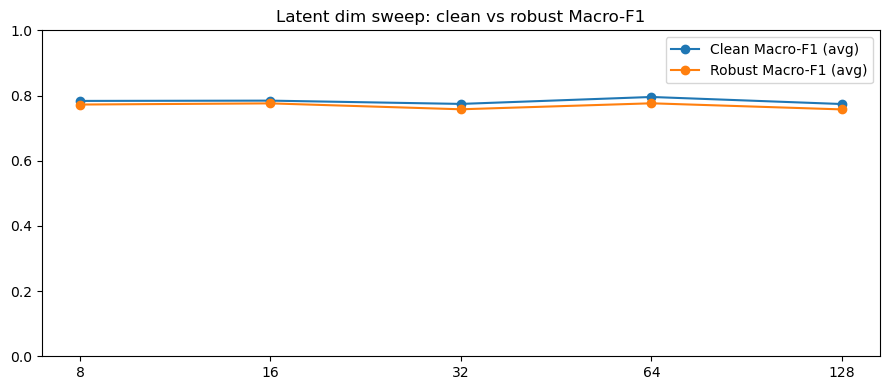


Done.


In [5]:
#!/usr/bin/env python
# coding: utf-8

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import f1_score, accuracy_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# >>> CHANGE THIS to your local folder that contains "train" and "val"
PATH_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(PATH_ROOT, "train")
VAL_DIR   = os.path.join(PATH_ROOT, "val")

IMG_H, IMG_W, CH = 128, 128, 3

LATENT_DIMS = [8, 16, 32, 64, 128]

VAE_EPOCHS = 25
VAE_BS = 32
VAE_LR = 3e-4

BETA_MAX = 1.0
BETA_WARMUP_EPOCHS = 8

CLS_EPOCHS = 15
CLS_BS = 32
CLS_LR = 1e-3

NOISE_GAUSS_SIG_LAT = 0.10

# GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# -----------------------------
# 1) Dataset loader with FIXED label mapping
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    # 1) Build train first to get canonical class order
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names

    # 2) Force VAL to use SAME mapping (THIS is the correct API)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        class_names=class_names,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

def ds_to_numpy(ds):
    xs, ys = [], []
    for xb, yb in ds:
        xs.append(xb.numpy())
        ys.append(yb.numpy())
    X = np.concatenate(xs, axis=0).astype(np.float32)
    y = np.concatenate(ys, axis=0).astype(np.int64)
    return X, y

# -----------------------------
# 2) VAE pieces (Keras-safe KL via add_loss)
# -----------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

class KLDivergenceLayer(layers.Layer):
    def __init__(self, beta_init=0.0, logvar_clip=10.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = tf.Variable(beta_init, trainable=False, dtype=tf.float32, name="beta")
        self.logvar_clip = float(logvar_clip)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)

        kl_per_sample = -0.5 * tf.reduce_sum(
            1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1
        )
        kl = tf.reduce_mean(kl_per_sample)
        self.add_loss(self.beta * kl)
        return z_mean, z_log_var

class BetaWarmup(tf.keras.callbacks.Callback):
    def __init__(self, beta_max=1.0, warmup_epochs=10, layer_name="kl"):
        super().__init__()
        self.beta_max = float(beta_max)
        self.warmup_epochs = int(max(1, warmup_epochs))
        self.layer_name = layer_name
        self._kl_layer = None

    def _find_layer_recursive(self, model, name):
        # Search direct children
        for layer in model.layers:
            if layer.name == name:
                return layer
        # Search nested models
        for layer in model.layers:
            if isinstance(layer, tf.keras.Model):
                found = self._find_layer_recursive(layer, name)
                if found is not None:
                    return found
        return None

    def on_train_begin(self, logs=None):
        self._kl_layer = self._find_layer_recursive(self.model, self.layer_name)
        if self._kl_layer is None:
            raise ValueError(
                f"Could not find layer '{self.layer_name}' in model or nested submodels. "
                f"Top-level layers: {[l.name for l in self.model.layers]}"
            )
        # Sanity: must have beta variable
        if not hasattr(self._kl_layer, "beta"):
            raise ValueError(f"Layer '{self.layer_name}' found but has no attribute 'beta'.")

    def on_epoch_begin(self, epoch, logs=None):
        beta = self.beta_max * min(1.0, epoch / float(self.warmup_epochs))
        self._kl_layer.beta.assign(beta)


def build_cnn_vae(input_shape, latent_dim, beta_init=0.0):
    enc_in = layers.Input(shape=input_shape, name="vae_input")

    x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(enc_in)
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)

    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z_mean, z_log_var = KLDivergenceLayer(beta_init=beta_init, name="kl")([z_mean, z_log_var])
    z = Sampling(name="z_sample")([z_mean, z_log_var])

    encoder = Model(enc_in, [z_mean, z_log_var, z], name=f"encoder_k{latent_dim}")

    # Decoder
    h4, w4 = input_shape[0] // 16, input_shape[1] // 16
    dec_in = layers.Input(shape=(latent_dim,), name="dec_input")

    x = layers.Dense(h4 * w4 * 256, activation="relu")(dec_in)
    x = layers.Reshape((h4, w4, 256))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
    dec_out = layers.Conv2D(input_shape[2], 3, padding="same", activation="sigmoid")(x)

    decoder = Model(dec_in, dec_out, name=f"decoder_k{latent_dim}")

    z_mean_, z_log_var_, z_ = encoder(enc_in)
    recon = decoder(z_)
    vae = Model(enc_in, recon, name=f"vae_k{latent_dim}")

    return encoder, decoder, vae

# -----------------------------
# 3) Latent classifiers
# -----------------------------
def build_latent_cnn(latent_dim, n_classes, lr=1e-3):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = Model(inp, out, name=f"latent_cnn_k{latent_dim}")
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def build_latent_rnn(latent_dim, n_classes, lr=1e-3):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Bidirectional(layers.LSTM(96, return_sequences=False))(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(192, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = Model(inp, out, name=f"latent_rnn_k{latent_dim}")
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

# -----------------------------
# 4) Helpers
# -----------------------------
def get_latent_zmean(encoder, X, batch_size=64):
    z_list = []
    for i in range(0, len(X), batch_size):
        z_mean, z_logv, z_samp = encoder.predict(X[i:i+batch_size], verbose=0)
        z_list.append(z_mean.astype(np.float32))
    return np.vstack(z_list)

def eval_macro_f1(model, X, y_true):
    probs = model.predict(X, verbose=0)
    y_pred = np.argmax(probs, axis=1)
    f1m = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    return acc, f1m

# -----------------------------
# 5) Load ds + convert to numpy
# -----------------------------
print("Loading datasets with fixed label mapping...")
train_ds, val_ds, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=VAE_BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])

X_train, y_train = ds_to_numpy(train_ds)
X_val, y_val     = ds_to_numpy(val_ds)
print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# -----------------------------
# 6) Sweep
# -----------------------------
def train_one_k(latent_dim):
    t0 = time.time()

    encoder, decoder, vae = build_cnn_vae((IMG_H, IMG_W, CH), latent_dim, beta_init=0.0)
    vae.compile(optimizer=tf.keras.optimizers.Adam(VAE_LR),
                loss=tf.keras.losses.MeanSquaredError())

    vae.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=VAE_EPOCHS, batch_size=VAE_BS, verbose=1,
        callbacks=[
            BetaWarmup(beta_max=BETA_MAX, warmup_epochs=BETA_WARMUP_EPOCHS, layer_name="kl"),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
        ]
    )

    # quick recon/kl on subset
    sub = min(256, len(X_val))
    z_mean_val, z_logv_val, _ = encoder.predict(X_val[:sub], verbose=0)
    z_logv_val = np.clip(z_logv_val, -10, 10)
    kl_val = float(np.mean(-0.5 * np.sum(1.0 + z_logv_val - z_mean_val**2 - np.exp(z_logv_val), axis=1)))

    X_recon = vae.predict(X_val[:sub], verbose=0)
    recon_mse = float(np.mean((X_val[:sub] - X_recon) ** 2))

    # latent
    z_train = get_latent_zmean(encoder, X_train, batch_size=64)
    z_val   = get_latent_zmean(encoder, X_val,   batch_size=64)

    z_train_seq = z_train.reshape((-1, latent_dim, 1)).astype(np.float32)
    z_val_seq   = z_val.reshape((-1, latent_dim, 1)).astype(np.float32)

    z_lo = float(np.percentile(z_train, 0.5))
    z_hi = float(np.percentile(z_train, 99.5))

    # heads
    m_cnn = build_latent_cnn(latent_dim, num_classes, lr=CLS_LR)
    m_rnn = build_latent_rnn(latent_dim, num_classes, lr=CLS_LR)

    m_cnn.fit(
        z_train_seq, y_train,
        validation_data=(z_val_seq, y_val),
        epochs=CLS_EPOCHS, batch_size=CLS_BS, verbose=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]
    )
    m_rnn.fit(
        z_train_seq, y_train,
        validation_data=(z_val_seq, y_val),
        epochs=CLS_EPOCHS, batch_size=CLS_BS, verbose=1,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]
    )

    # clean
    _, f1_cnn = eval_macro_f1(m_cnn, z_val_seq, y_val)
    _, f1_rnn = eval_macro_f1(m_rnn, z_val_seq, y_val)
    clean_avg = 0.5 * (f1_cnn + f1_rnn)

    # robust (latent gaussian)
    z_val_noisy = z_val_seq + np.random.normal(0, NOISE_GAUSS_SIG_LAT, size=z_val_seq.shape).astype(np.float32)
    z_val_noisy = np.clip(z_val_noisy, z_lo, z_hi).astype(np.float32)

    _, f1_cnn_r = eval_macro_f1(m_cnn, z_val_noisy, y_val)
    _, f1_rnn_r = eval_macro_f1(m_rnn, z_val_noisy, y_val)
    robust_avg = 0.5 * (f1_cnn_r + f1_rnn_r)

    elapsed_min = (time.time() - t0) / 60.0

    return {
        "k": latent_dim,
        "recon_mse_val(sub256)": recon_mse,
        "kl_val(sub256)": kl_val,
        "clean_macroF1_avg": clean_avg,
        "robust_macroF1_avg": robust_avg,
        "time_min": elapsed_min
    }

rows = []
print("\n" + "="*80)
print("Starting latent dimension sweep...")
for k in LATENT_DIMS:
    print("\n" + "="*80)
    print(f"[SWEEP] Latent dim k={k}")
    row = train_one_k(k)
    rows.append(row)
    print(f"[DONE k={k}] clean_avg={row['clean_macroF1_avg']:.4f} "
          f"robust_avg={row['robust_macroF1_avg']:.4f} "
          f"recon={row['recon_mse_val(sub256)']:.6f} "
          f"kl={row['kl_val(sub256)']:.2f} time={row['time_min']:.1f} min")

sweep_df = pd.DataFrame(rows).sort_values("k")
print("\n=== SWEEP RESULTS ===")
print(sweep_df.to_string(index=False))
sweep_df.to_csv("latent_dim_sweep_results.csv", index=False)
print("\nSaved: latent_dim_sweep_results.csv")

best = sweep_df.sort_values(["robust_macroF1_avg", "clean_macroF1_avg"], ascending=[False, False]).iloc[0]
print("\n=== SELECTED k ===")
print(best.to_string())

plt.figure(figsize=(9, 4))
plt.plot(sweep_df["k"], sweep_df["clean_macroF1_avg"], marker="o", label="Clean Macro-F1 (avg)")
plt.plot(sweep_df["k"], sweep_df["robust_macroF1_avg"], marker="o", label="Robust Macro-F1 (avg)")
plt.xscale("log", base=2)
plt.xticks(LATENT_DIMS, LATENT_DIMS)
plt.ylim(0, 1)
plt.title("Latent dim sweep: clean vs robust Macro-F1")
plt.legend()
plt.tight_layout()
plt.show()

print("\nDone.")


In [7]:
#!/usr/bin/env python
# coding: utf-8

"""
MaleVis: VAE Latent -> (CNN + RNN) with Clean + Perturbations + Adversarial (Latent Space)

Key features:
- Uses local directory with train/ and val/
- FIXED class mapping: val uses class_names from train (prevents label mismatch)
- Streaming tf.data (NO ds_to_numpy)
- VAE uses KL warmup via model.beta (no missing 'kl' layer)
- Classifiers use deterministic z_mean (stable)
- Evaluates: Clean + Gaussian/Uniform/Dropout/SaltPepper + FGSM/PGD on latent

Output:
- Prints results table
- Saves: malevis_latent_cnn_rnn_results.csv
"""

import os, gc, time, math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

IMG_H, IMG_W, CH = 128, 128, 3
LATENT_DIM = 64  # set to your chosen k (or best_k from sweep)

# VAE
VAE_EPOCHS = 25
VAE_BS     = 8
VAE_LR     = 1e-3

# KL warmup
BETA_MAX = 1.0
BETA_WARMUP_EPOCHS = 10

# Classifiers
CLS_EPOCHS = 15
CLS_BS     = 128
CLS_LR     = 1e-3

# Latent perturbations
NOISE_GAUSS_SIG = 0.15
NOISE_UNIF_RNG  = 0.15
NOISE_DROPOUT   = 0.25
NOISE_SP_PROB   = 0.02

# Adversarial (latent, Linf)
FGSM_EPS_LAT   = 0.25
PGD_EPS_LAT    = 0.35
PGD_ALPHA_LAT  = 0.06
PGD_ITERS_LAT  = 10

# GPU memory growth (safe)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


# -----------------------------
# 1) Dataset loading (FIXED mapping)
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names  # canonical mapping

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names   # <-- critical fix
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    # DON'T cache images in RAM for 300x300; just prefetch
    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets with fixed label mapping...")
train_ds_vae, val_ds_vae, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=VAE_BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])


# -----------------------------
# 2) Conv VAE (subclassed, beta warmup)
# -----------------------------
def _compute_decoder_grid(img_h, img_w, downsamples=4):
    div = 2 ** downsamples
    gh = int(math.ceil(img_h / div))
    gw = int(math.ceil(img_w / div))
    out_h = gh * div
    out_w = gw * div
    return gh, gw, out_h, out_w

def build_encoder(input_shape, latent_dim):
    inp = layers.Input(shape=input_shape, name=f"enc_in_k{latent_dim}")
    x = layers.Conv2D(32, 4, strides=2, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name=f"z_mean_k{latent_dim}")(x)
    z_log_var = layers.Dense(latent_dim, name=f"z_log_var_k{latent_dim}")(x)
    return tf.keras.Model(inp, [z_mean, z_log_var], name=f"encoder_k{latent_dim}")

def build_decoder(output_shape, latent_dim):
    img_h, img_w, ch = output_shape
    gh, gw, out_h, out_w = _compute_decoder_grid(img_h, img_w, downsamples=4)

    inp = layers.Input(shape=(latent_dim,), name=f"dec_in_k{latent_dim}")
    x = layers.Dense(gh * gw * 256, activation="relu")(inp)
    x = layers.Reshape((gh, gw, 256))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(ch, 3, padding="same", activation="sigmoid")(x)

    crop_h = max(0, out_h - img_h)
    crop_w = max(0, out_w - img_w)
    if crop_h > 0 or crop_w > 0:
        top = crop_h // 2
        bot = crop_h - top
        left = crop_w // 2
        right = crop_w - left
        x = layers.Cropping2D(cropping=((top, bot), (left, right)))(x)

    return tf.keras.Model(inp, x, name=f"decoder_k{latent_dim}")

class ConvVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, logvar_clip=10.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32, name="beta")
        self.logvar_clip = float(logvar_clip)

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_tracker = tf.keras.metrics.Mean(name="recon_sse")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")

    @property
    def metrics(self):
        return [self.loss_tracker, self.recon_tracker, self.kl_tracker]

    def _sample(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
            z = self._sample(z_mean, z_log_var)
            x_hat = self.decoder(z, training=True)

            recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
            kl = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            loss = recon_sse + self.beta * kl

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x, training=False)
        z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
        z = self._sample(z_mean, z_log_var)
        x_hat = self.decoder(z, training=False)

        recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
        kl = tf.reduce_mean(
            -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        loss = recon_sse + self.beta * kl

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def encode_mean(self, x):
        z_mean, _ = self.encoder(x, training=False)
        return z_mean

class BetaWarmup(tf.keras.callbacks.Callback):
    def __init__(self, beta_max=1.0, warmup_epochs=10):
        super().__init__()
        self.beta_max = float(beta_max)
        self.warmup_epochs = int(max(1, warmup_epochs))

    def on_epoch_begin(self, epoch, logs=None):
        beta = self.beta_max * min(1.0, epoch / float(self.warmup_epochs))
        self.model.beta.assign(beta)


# Train VAE (images only)
print("\nTraining VAE...")
tf.keras.backend.clear_session()
encoder = build_encoder((IMG_H, IMG_W, CH), LATENT_DIM)
decoder = build_decoder((IMG_H, IMG_W, CH), LATENT_DIM)
vae = ConvVAE(encoder, decoder, name=f"vae_k{LATENT_DIM}")
vae.compile(optimizer=tf.keras.optimizers.Adam(VAE_LR))

vae_train_img = train_ds_vae.map(lambda x, y: x)
vae_val_img   = val_ds_vae.map(lambda x, y: x)

vae.fit(
    vae_train_img,
    validation_data=vae_val_img,
    epochs=VAE_EPOCHS,
    verbose=1,
    callbacks=[
        BetaWarmup(beta_max=BETA_MAX, warmup_epochs=BETA_WARMUP_EPOCHS),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ]
)


# -----------------------------
# 3) Build latent datasets (cache latents, safe)
# -----------------------------
def make_image_ds(dir_path, class_names, img_size, batch_size, shuffle, seed):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed if shuffle else None,
        class_names=class_names
    )

    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_cls = make_image_ds(TRAIN_DIR, class_names, (IMG_H, IMG_W), CLS_BS, shuffle=True,  seed=SEED)
val_ds_cls   = make_image_ds(VAL_DIR,   class_names, (IMG_H, IMG_W), CLS_BS, shuffle=False, seed=SEED)

def make_latent_ds(image_ds, vae, cache_latents=True, shuffle=False):
    def to_latent(x, y):
        z = vae.encode_mean(x)          # (B,k)
        z = tf.expand_dims(z, axis=-1)  # (B,k,1)
        return z, y

    out = image_ds.map(to_latent, num_parallel_calls=tf.data.AUTOTUNE)
    if cache_latents:
        out = out.cache()
    if shuffle:
        out = out.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    return out.prefetch(tf.data.AUTOTUNE)

lat_train_ds = make_latent_ds(train_ds_cls, vae, cache_latents=True, shuffle=True)
lat_val_ds   = make_latent_ds(val_ds_cls,   vae, cache_latents=True, shuffle=False)

def estimate_latent_bounds(latent_ds, q_lo=0.5, q_hi=99.5, take_batches=50):
    zs = []
    for zb, _ in latent_ds.take(take_batches):
        zs.append(tf.reshape(zb, [-1]).numpy())
    zs = np.concatenate(zs, axis=0)
    return float(np.percentile(zs, q_lo)), float(np.percentile(zs, q_hi))

z_min, z_max = estimate_latent_bounds(lat_train_ds)
print("\nLatent clip bounds:", z_min, z_max)


# -----------------------------
# 4) Build latent CNN + latent RNN
# -----------------------------
def build_latent_cnn(latent_dim, n_classes):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = tf.keras.Model(inp, out, name="latent_cnn")
    m.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return m

def build_latent_rnn(latent_dim, n_classes):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Bidirectional(layers.LSTM(96, return_sequences=False))(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(192, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = tf.keras.Model(inp, out, name="latent_rnn")
    m.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return m

cnn_lat = build_latent_cnn(LATENT_DIM, num_classes)
rnn_lat = build_latent_rnn(LATENT_DIM, num_classes)

print("\nTraining Latent CNN...")
cnn_lat.fit(
    lat_train_ds,
    validation_data=lat_val_ds,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)

print("\nTraining Latent RNN...")
rnn_lat.fit(
    lat_train_ds,
    validation_data=lat_val_ds,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)


# -----------------------------
# 5) Latent perturbations + attacks
# -----------------------------
def clip_latent(z):
    return tf.clip_by_value(z, z_min, z_max)

def latent_noise(z, kind):
    if kind == "Gaussian":
        z2 = z + tf.random.normal(tf.shape(z), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        z2 = z + tf.random.uniform(tf.shape(z), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(z)) > NOISE_DROPOUT, tf.float32)
        z2 = z * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(z))
        z2 = tf.where(rnd < (NOISE_SP_PROB/2.0), tf.cast(z_min, tf.float32), z)
        z2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), tf.cast(z_max, tf.float32), z2)
    else:
        raise ValueError("Unknown noise kind")
    return clip_latent(z2)

cce_sparse = tf.keras.losses.SparseCategoricalCrossentropy()

def fgsm_latent(model, z, y, eps):
    z = tf.identity(z)
    with tf.GradientTape() as tape:
        tape.watch(z)
        probs = model(z, training=False)
        loss = cce_sparse(y, probs)
    grad = tape.gradient(loss, z)
    z_adv = z + eps * tf.sign(grad)
    return clip_latent(z_adv)

def pgd_latent(model, z0, y, eps, alpha, iters):
    z_adv = z0 + tf.random.uniform(tf.shape(z0), minval=-eps, maxval=eps)
    z_adv = clip_latent(z_adv)
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(z_adv)
            probs = model(z_adv, training=False)
            loss = cce_sparse(y, probs)
        grad = tape.gradient(loss, z_adv)
        z_adv = z_adv + alpha * tf.sign(grad)

        delta = tf.clip_by_value(z_adv - z0, -eps, eps)
        z_adv = clip_latent(z0 + delta)
    return z_adv


# -----------------------------
# 6) Evaluation on Clean + Perturbations + Adversarial
# -----------------------------
def eval_model_on_condition(model, latent_ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()

    for zb, yb in latent_ds:
        if condition == "Clean":
            z_eval = zb
        elif condition in ["Gaussian", "Uniform", "Dropout", "Salt-Pepper"]:
            z_eval = latent_noise(zb, condition)
        elif condition == "FGSM":
            z_eval = fgsm_latent(model, zb, yb, FGSM_EPS_LAT)
        elif condition == "PGD":
            z_eval = pgd_latent(model, zb, yb, PGD_EPS_LAT, PGD_ALPHA_LAT, PGD_ITERS_LAT)
        else:
            raise ValueError("Unknown condition")

        probs = model(z_eval, training=False)
        pred = tf.argmax(probs, axis=1)

        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    acc = float(accuracy_score(y_true, y_pred))
    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
    elapsed = float(time.time() - t0)

    return acc, macro_f1, elapsed

conditions = ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper", "FGSM", "PGD"]

results = []
for mname, model in [("Latent-CNN", cnn_lat), ("Latent-RNN", rnn_lat)]:
    print(f"\nEvaluating {mname} ...")
    for cond in conditions:
        acc, mf1, sec = eval_model_on_condition(model, lat_val_ds, cond)
        results.append({"Model": mname, "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
        print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

df = pd.DataFrame(results).sort_values(["Condition", "Model"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

df.to_csv("malevis_latent_cnn_rnn_results.csv", index=False)
print("\nSaved: malevis_latent_cnn_rnn_results.csv")
print("Done.")


Loading datasets with fixed label mapping...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Classes: 26
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']

Training VAE...
Epoch 1/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 409s 353ms/step - kl: 2126.3662 - loss: 2210.0642 - recon_sse: 2210.0642 - val_kl: 855.5303 - val_loss: 1460.1569 - val_recon_sse: 1460.1569
Epoch 2/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 410s 360ms/step - kl: 214.6332 - loss: 1423.1990 - recon_sse: 1401.7358 - val_kl: 129.7855 - val_loss: 1331.0577 - val_recon_sse: 1318.0806
Epoch 3/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 393s 346ms/step - kl: 118.5630 - loss: 1226.2263 - recon_sse: 1202.5138 - val_kl: 111.7611 - val_loss: 1209.7183 - val_recon_sse: 1187.3665
Epoch 4/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 390s 342ms/step - kl: 99.6874 - loss: 1110.9768 - recon_sse: 1081.0704 - val_kl: 94.6058 - val_loss: 1137.2623 - val_recon_sse: 1108.8807
Epoch 5/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
#!/usr/bin/env python
# coding: utf-8

"""
MaleVis: VAE Latent -> (CNN + RNN) with Clean + Perturbations + Adversarial (Latent Space)

Key features:
- Uses local directory with train/ and val/
- FIXED class mapping: val uses class_names from train (prevents label mismatch)
- Streaming tf.data (NO ds_to_numpy)
- VAE uses KL warmup via model.beta (no missing 'kl' layer)
- Classifiers use deterministic z_mean (stable)
- Evaluates: Clean + Gaussian/Uniform/Dropout/SaltPepper + FGSM/PGD on latent

Output:
- Prints results table
- Saves: malevis_latent_cnn_rnn_results.csv
"""

import os, gc, time, math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

IMG_H, IMG_W, CH = 300, 300, 3
LATENT_DIM = 64  # set to your chosen k (or best_k from sweep)

# VAE
VAE_EPOCHS = 25
VAE_BS     = 8
VAE_LR     = 1e-3

# KL warmup
BETA_MAX = 1.0
BETA_WARMUP_EPOCHS = 10

# Classifiers
CLS_EPOCHS = 15
CLS_BS     = 128
CLS_LR     = 1e-3

# Latent perturbations
NOISE_GAUSS_SIG = 0.15
NOISE_UNIF_RNG  = 0.15
NOISE_DROPOUT   = 0.25
NOISE_SP_PROB   = 0.02

# Adversarial (latent, Linf)
FGSM_EPS_LAT   = 0.25
PGD_EPS_LAT    = 0.35
PGD_ALPHA_LAT  = 0.06
PGD_ITERS_LAT  = 10

# GPU memory growth (safe)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


# -----------------------------
# 1) Dataset loading (FIXED mapping)
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names  # canonical mapping

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names   # <-- critical fix
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    # DON'T cache images in RAM for 300x300; just prefetch
    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets with fixed label mapping...")
train_ds_vae, val_ds_vae, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=VAE_BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])


# -----------------------------
# 2) Conv VAE (subclassed, beta warmup)
# -----------------------------
def _compute_decoder_grid(img_h, img_w, downsamples=4):
    div = 2 ** downsamples
    gh = int(math.ceil(img_h / div))
    gw = int(math.ceil(img_w / div))
    out_h = gh * div
    out_w = gw * div
    return gh, gw, out_h, out_w

def build_encoder(input_shape, latent_dim):
    inp = layers.Input(shape=input_shape, name=f"enc_in_k{latent_dim}")
    x = layers.Conv2D(32, 4, strides=2, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name=f"z_mean_k{latent_dim}")(x)
    z_log_var = layers.Dense(latent_dim, name=f"z_log_var_k{latent_dim}")(x)
    return tf.keras.Model(inp, [z_mean, z_log_var], name=f"encoder_k{latent_dim}")

def build_decoder(output_shape, latent_dim):
    img_h, img_w, ch = output_shape
    gh, gw, out_h, out_w = _compute_decoder_grid(img_h, img_w, downsamples=4)

    inp = layers.Input(shape=(latent_dim,), name=f"dec_in_k{latent_dim}")
    x = layers.Dense(gh * gw * 256, activation="relu")(inp)
    x = layers.Reshape((gh, gw, 256))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(ch, 3, padding="same", activation="sigmoid")(x)

    crop_h = max(0, out_h - img_h)
    crop_w = max(0, out_w - img_w)
    if crop_h > 0 or crop_w > 0:
        top = crop_h // 2
        bot = crop_h - top
        left = crop_w // 2
        right = crop_w - left
        x = layers.Cropping2D(cropping=((top, bot), (left, right)))(x)

    return tf.keras.Model(inp, x, name=f"decoder_k{latent_dim}")

class ConvVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, logvar_clip=10.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32, name="beta")
        self.logvar_clip = float(logvar_clip)

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_tracker = tf.keras.metrics.Mean(name="recon_sse")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")

    @property
    def metrics(self):
        return [self.loss_tracker, self.recon_tracker, self.kl_tracker]

    def _sample(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
            z = self._sample(z_mean, z_log_var)
            x_hat = self.decoder(z, training=True)

            recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
            kl = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            loss = recon_sse + self.beta * kl

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x, training=False)
        z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
        z = self._sample(z_mean, z_log_var)
        x_hat = self.decoder(z, training=False)

        recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
        kl = tf.reduce_mean(
            -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        loss = recon_sse + self.beta * kl

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def encode_mean(self, x):
        z_mean, _ = self.encoder(x, training=False)
        return z_mean

class BetaWarmup(tf.keras.callbacks.Callback):
    def __init__(self, beta_max=1.0, warmup_epochs=10):
        super().__init__()
        self.beta_max = float(beta_max)
        self.warmup_epochs = int(max(1, warmup_epochs))

    def on_epoch_begin(self, epoch, logs=None):
        beta = self.beta_max * min(1.0, epoch / float(self.warmup_epochs))
        self.model.beta.assign(beta)


# Train VAE (images only)
print("\nTraining VAE...")
tf.keras.backend.clear_session()
encoder = build_encoder((IMG_H, IMG_W, CH), LATENT_DIM)
decoder = build_decoder((IMG_H, IMG_W, CH), LATENT_DIM)
vae = ConvVAE(encoder, decoder, name=f"vae_k{LATENT_DIM}")
vae.compile(optimizer=tf.keras.optimizers.Adam(VAE_LR))

vae_train_img = train_ds_vae.map(lambda x, y: x)
vae_val_img   = val_ds_vae.map(lambda x, y: x)

vae.fit(
    vae_train_img,
    validation_data=vae_val_img,
    epochs=VAE_EPOCHS,
    verbose=1,
    callbacks=[
        BetaWarmup(beta_max=BETA_MAX, warmup_epochs=BETA_WARMUP_EPOCHS),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ]
)


# -----------------------------
# 3) Build latent datasets (cache latents, safe)
# -----------------------------
def make_image_ds(dir_path, class_names, img_size, batch_size, shuffle, seed):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed if shuffle else None,
        class_names=class_names
    )

    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_cls = make_image_ds(TRAIN_DIR, class_names, (IMG_H, IMG_W), CLS_BS, shuffle=True,  seed=SEED)
val_ds_cls   = make_image_ds(VAL_DIR,   class_names, (IMG_H, IMG_W), CLS_BS, shuffle=False, seed=SEED)

def make_latent_ds(image_ds, vae, cache_latents=True, shuffle=False):
    def to_latent(x, y):
        z = vae.encode_mean(x)          # (B,k)
        z = tf.expand_dims(z, axis=-1)  # (B,k,1)
        return z, y

    out = image_ds.map(to_latent, num_parallel_calls=tf.data.AUTOTUNE)
    if cache_latents:
        out = out.cache()
    if shuffle:
        out = out.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    return out.prefetch(tf.data.AUTOTUNE)

lat_train_ds = make_latent_ds(train_ds_cls, vae, cache_latents=True, shuffle=True)
lat_val_ds   = make_latent_ds(val_ds_cls,   vae, cache_latents=True, shuffle=False)

def estimate_latent_bounds(latent_ds, q_lo=0.5, q_hi=99.5, take_batches=50):
    zs = []
    for zb, _ in latent_ds.take(take_batches):
        zs.append(tf.reshape(zb, [-1]).numpy())
    zs = np.concatenate(zs, axis=0)
    return float(np.percentile(zs, q_lo)), float(np.percentile(zs, q_hi))

z_min, z_max = estimate_latent_bounds(lat_train_ds)
print("\nLatent clip bounds:", z_min, z_max)


# -----------------------------
# 4) Build latent CNN + latent RNN
# -----------------------------
def build_latent_cnn(latent_dim, n_classes):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = tf.keras.Model(inp, out, name="latent_cnn")
    m.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return m

def build_latent_rnn(latent_dim, n_classes):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Bidirectional(layers.LSTM(96, return_sequences=False))(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(192, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = tf.keras.Model(inp, out, name="latent_rnn")
    m.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return m

cnn_lat = build_latent_cnn(LATENT_DIM, num_classes)
rnn_lat = build_latent_rnn(LATENT_DIM, num_classes)

print("\nTraining Latent CNN...")
cnn_lat.fit(
    lat_train_ds,
    validation_data=lat_val_ds,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)

print("\nTraining Latent RNN...")
rnn_lat.fit(
    lat_train_ds,
    validation_data=lat_val_ds,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)


# -----------------------------
# 5) Latent perturbations + attacks
# -----------------------------
def clip_latent(z):
    return tf.clip_by_value(z, z_min, z_max)

def latent_noise(z, kind):
    if kind == "Gaussian":
        z2 = z + tf.random.normal(tf.shape(z), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        z2 = z + tf.random.uniform(tf.shape(z), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(z)) > NOISE_DROPOUT, tf.float32)
        z2 = z * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(z))
        z2 = tf.where(rnd < (NOISE_SP_PROB/2.0), tf.cast(z_min, tf.float32), z)
        z2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), tf.cast(z_max, tf.float32), z2)
    else:
        raise ValueError("Unknown noise kind")
    return clip_latent(z2)

cce_sparse = tf.keras.losses.SparseCategoricalCrossentropy()

def fgsm_latent(model, z, y, eps):
    z = tf.identity(z)
    with tf.GradientTape() as tape:
        tape.watch(z)
        probs = model(z, training=False)
        loss = cce_sparse(y, probs)
    grad = tape.gradient(loss, z)
    z_adv = z + eps * tf.sign(grad)
    return clip_latent(z_adv)

def pgd_latent(model, z0, y, eps, alpha, iters):
    z_adv = z0 + tf.random.uniform(tf.shape(z0), minval=-eps, maxval=eps)
    z_adv = clip_latent(z_adv)
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(z_adv)
            probs = model(z_adv, training=False)
            loss = cce_sparse(y, probs)
        grad = tape.gradient(loss, z_adv)
        z_adv = z_adv + alpha * tf.sign(grad)

        delta = tf.clip_by_value(z_adv - z0, -eps, eps)
        z_adv = clip_latent(z0 + delta)
    return z_adv


# -----------------------------
# 6) Evaluation on Clean + Perturbations + Adversarial
# -----------------------------
def eval_model_on_condition(model, latent_ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()

    for zb, yb in latent_ds:
        if condition == "Clean":
            z_eval = zb
        elif condition in ["Gaussian", "Uniform", "Dropout", "Salt-Pepper"]:
            z_eval = latent_noise(zb, condition)
        elif condition == "FGSM":
            z_eval = fgsm_latent(model, zb, yb, FGSM_EPS_LAT)
        elif condition == "PGD":
            z_eval = pgd_latent(model, zb, yb, PGD_EPS_LAT, PGD_ALPHA_LAT, PGD_ITERS_LAT)
        else:
            raise ValueError("Unknown condition")

        probs = model(z_eval, training=False)
        pred = tf.argmax(probs, axis=1)

        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    acc = float(accuracy_score(y_true, y_pred))
    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
    elapsed = float(time.time() - t0)

    return acc, macro_f1, elapsed

conditions = ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper", "FGSM", "PGD"]

results = []
for mname, model in [("Latent-CNN", cnn_lat), ("Latent-RNN", rnn_lat)]:
    print(f"\nEvaluating {mname} ...")
    for cond in conditions:
        acc, mf1, sec = eval_model_on_condition(model, lat_val_ds, cond)
        results.append({"Model": mname, "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
        print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

df = pd.DataFrame(results).sort_values(["Condition", "Model"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

df.to_csv("malevis_latent_cnn_rnn_results.csv", index=False)
print("\nSaved: malevis_latent_cnn_rnn_results.csv")
print("Done.")


Loading datasets with fixed label mapping...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Classes: 26
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']

Training VAE...
Epoch 1/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2589s 2s/step - kl: 1430.3793 - loss: 17699.2090 - recon_sse: 17699.2090 - val_kl: 523.2974 - val_loss: 12347.1885 - val_recon_sse: 12347.1885
Epoch 2/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2585s 2s/step - kl: 407.2189 - loss: 12004.5361 - recon_sse: 11963.8184 - val_kl: 301.9803 - val_loss: 10930.0068 - val_recon_sse: 10899.8076
Epoch 3/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2588s 2s/step - kl: 263.2910 - loss: 10512.8809 - recon_sse: 10460.2217 - val_kl: 208.0231 - val_loss: 10480.4053 - val_recon_sse: 10438.8047
Epoch 4/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2606s 2s/step - kl: 203.1589 - loss: 9889.6133 - recon_sse: 9828.6650 - val_kl: 182.3593 - val_loss: 10133.3496 - val_recon_sse: 10078.6348
Epoch 5/25
1138/1138 ━━━━━━━━━━━━━

In [18]:
#!/usr/bin/env python
# coding: utf-8
"""
MaleVis (IMAGE SPACE):
CNN classifier with:
- Clean evaluation
- Noise perturbations: Gaussian / Uniform / Dropout / Salt-Pepper
- Adversarial attacks via ART: FGSM / PGD / HopSkipJump / BoundaryAttack

Key features:
- Uses local directory with train/ and val/
- FIXED class mapping: val uses class_names from train (prevents label mismatch)
- Streaming tf.data for training/eval (no ds_to_numpy)
- Adversarial attacks run on a SMALL SUBSET (ADV_MAX_SAMPLES) to avoid RAM blowups
- Uses ART TensorFlowV2Classifier (works with TF2 eager)

Output:
- Prints results table
- Saves: malevis_image_cnn_noise_adv_results.csv
"""

import os, time, gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

# If you insist on 300x300, keep it.
# If RAM/GPU memory becomes painful, drop to 128 or 224.
IMG_H, IMG_W, CH = 300, 300, 3

# Training
EPOCHS = 15
BS     = 32
LR     = 1e-3

# Noise perturbations (image-space)
NOISE_GAUSS_SIG = 0.10
NOISE_UNIF_RNG  = 0.10
NOISE_DROPOUT   = 0.20
NOISE_SP_PROB   = 0.02

# Adversarial subset (IMPORTANT for memory/time)
ADV_MAX_SAMPLES = 64     # increase slowly (e.g., 128, 256) if you have RAM
ADV_BATCH_SIZE  = 8      # keep small for 300x300

# FGSM/PGD (Linf) eps in [0,1] pixel space
FGSM_EPS = 8/255
PGD_EPS  = 8/255
PGD_ALPHA = 2/255
PGD_ITERS = 10

# HSJ / Boundary (black-box) — slow, keep small subset
HSJ_MAX_ITER    = 20
HSJ_MAX_EVAL    = 2000
HSJ_INIT_EVAL   = 50
HSJ_INIT_SIZE   = 50

BOUNDARY_MAX_ITER = 200
BOUNDARY_DELTA    = 0.01
BOUNDARY_EPS      = 0.01

# GPU memory growth (safe)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


# -----------------------------
# 1) Dataset loading (FIXED mapping)
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names  # canonical mapping

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets with fixed label mapping...")
train_ds, val_ds, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])


# -----------------------------
# 2) CNN model (logits output for stability)
# -----------------------------
def build_cnn(num_classes):
    inp = layers.Input(shape=(IMG_H, IMG_W, CH))
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    logits = layers.Dense(num_classes, activation=None, name="logits")(x)  # <-- logits
    model = tf.keras.Model(inp, logits, name="malevis_cnn_logits")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

cnn = build_cnn(num_classes)

print("\nTraining CNN...")
cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)

print("\nSanity check (Keras evaluate on CLEAN val):", cnn.evaluate(val_ds, verbose=0))


# -----------------------------
# 3) Noise perturbations (streaming, no numpy)
# -----------------------------
def clip01(x):
    return tf.clip_by_value(x, 0.0, 1.0)

def add_noise_batch(x, kind):
    if kind == "Gaussian":
        x2 = x + tf.random.normal(tf.shape(x), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        x2 = x + tf.random.uniform(tf.shape(x), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(x)) > NOISE_DROPOUT, tf.float32)
        x2 = x * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(x))
        x2 = tf.where(rnd < (NOISE_SP_PROB/2.0), 0.0, x)
        x2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), 1.0, x2)
    else:
        raise ValueError("Unknown noise kind")
    return clip01(x2)

@tf.function
def predict_labels_logits(model, x):
    logits = model(x, training=False)
    return tf.argmax(logits, axis=1)

def eval_streaming_condition(model, ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()
    for xb, yb in ds:
        if condition == "Clean":
            x_eval = xb
        else:
            x_eval = add_noise_batch(xb, condition)
        pred = predict_labels_logits(model, x_eval)
        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    acc = float(accuracy_score(y_true, y_pred))
    mf1 = float(f1_score(y_true, y_pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec


# -----------------------------
# 4) ART setup (TF2 eager-safe) + attacks
# -----------------------------
def require_art():
    try:
        import art  # noqa: F401
        return True
    except Exception as e:
        raise ImportError(
            "ART is required for FGSM/PGD/HSJ/Boundary.\n"
            "Install it:\n"
            "  pip install adversarial-robustness-toolbox\n"
            "Then RESTART kernel / Python.\n"
            f"Original import error: {e}"
        )

require_art()
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, HopSkipJump, BoundaryAttack

# ART expects one-hot for CategoricalCrossentropy most reliably
loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

art_clf = TensorFlowV2Classifier(
    model=cnn,
    nb_classes=num_classes,
    input_shape=(IMG_H, IMG_W, CH),
    loss_object=loss_obj,
    optimizer=optimizer,
    clip_values=(0.0, 1.0),
)

fgsm = FastGradientMethod(estimator=art_clf, eps=FGSM_EPS)
pgd  = ProjectedGradientDescent(
    estimator=art_clf,
    eps=PGD_EPS,
    eps_step=PGD_ALPHA,
    max_iter=PGD_ITERS,
    targeted=False
)

# Handle ART API variations for HSJ/Boundary (estimator= vs classifier=)
def make_hsj(estimator):
    try:
        return HopSkipJump(
            estimator=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )
    except TypeError:
        return HopSkipJump(
            classifier=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )

def make_boundary(estimator):
    try:
        return BoundaryAttack(
            estimator=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )
    except TypeError:
        return BoundaryAttack(
            classifier=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )

hsj = make_hsj(art_clf)
bnd = make_boundary(art_clf)


# -----------------------------
# 5) Adversarial evaluation (subset -> numpy)
# -----------------------------
def take_numpy_subset(ds, max_samples):
    Xs, Ys = [], []
    n = 0
    for xb, yb in ds:
        Xs.append(xb.numpy().astype(np.float32))
        Ys.append(yb.numpy().astype(np.int64))
        n += len(yb)
        if n >= max_samples:
            break
    X = np.concatenate(Xs, axis=0)[:max_samples]
    y = np.concatenate(Ys, axis=0)[:max_samples]
    y_oh = tf.keras.utils.to_categorical(y, num_classes=num_classes).astype(np.float32)
    return X, y, y_oh

def eval_attack_on_subset(attack, ds, max_samples, batch_size):
    X, y, y_oh = take_numpy_subset(ds, max_samples=max_samples)
    t0 = time.time()
    # many ART attacks accept y optional; providing y usually helps
    try:
        X_adv = attack.generate(x=X, y=y_oh, batch_size=batch_size)
    except Exception:
        X_adv = attack.generate(x=X, y=y, batch_size=batch_size)

    # evaluate with logits
    logits = cnn(tf.convert_to_tensor(X_adv, dtype=tf.float32), training=False).numpy()
    pred = logits.argmax(axis=1)
    acc = float(accuracy_score(y, pred))
    mf1 = float(f1_score(y, pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec


# -----------------------------
# 6) Run evals + save
# -----------------------------
conditions_noise = ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper"]
conditions_adv   = ["FGSM", "PGD", "HopSkipJump", "Boundary"]

results = []

print("\nEvaluating CNN (noise / clean) ...")
for cond in conditions_noise:
    acc, mf1, sec = eval_streaming_condition(cnn, val_ds, cond)
    results.append({"Model": "CNN-Image", "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
    print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

print(f"\nEvaluating CNN (adversarial on first {ADV_MAX_SAMPLES} samples) ...")
acc, mf1, sec = eval_attack_on_subset(fgsm, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "CNN-Image", "Condition": "FGSM", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  FGSM         acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(pgd, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "CNN-Image", "Condition": "PGD", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  PGD          acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(hsj, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "CNN-Image", "Condition": "HopSkipJump", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  HopSkipJump  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(bnd, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "CNN-Image", "Condition": "Boundary", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  Boundary     acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

df = pd.DataFrame(results).sort_values(["Condition"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

out_csv = "malevis_image_cnn_noise_adv_results.csv"
df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")
print("Done.")


Loading datasets with fixed label mapping...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Classes: 26
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']

Training CNN...
Epoch 1/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 804s 3s/step - accuracy: 0.1802 - loss: 2.7967 - val_accuracy: 0.4278 - val_loss: 2.2236
Epoch 2/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 782s 3s/step - accuracy: 0.5491 - loss: 1.6089 - val_accuracy: 0.6030 - val_loss: 1.5905
Epoch 3/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 780s 3s/step - accuracy: 0.6708 - loss: 1.1940 - val_accuracy: 0.6528 - val_loss: 1.4124
Epoch 4/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 781s 3s/step - accuracy: 0.7408 - loss: 0.9129 - val_accuracy: 0.7298 - val_loss: 1.3171
Epoch 5/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 786s 3s/step - accuracy: 0.7938 - loss: 0.7511 - val_accuracy: 0.7284 - val_loss: 1.3466
Epoch 6/15
285/285 ━━━━━━━━━━━━━━━━━━━━ 791s 3s/step - accuracy: 0.8201 - loss: 0.6493 - val_accuracy: 0.7522 - val_loss: 1.

PGD - Batches: 0it [00:00, ?it/s]

  PGD          acc=0.6406  macroF1=0.2603  time=66.6s


HopSkipJump:   0%|          | 0/64 [00:00<?, ?it/s]

  HopSkipJump  acc=0.0000  macroF1=0.0000  time=9625.5s


Boundary attack:   0%|          | 0/64 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

  Boundary     acc=0.0312  macroF1=0.0152  time=13909.3s

RESULTS:
    Model   Condition  Accuracy  Macro-F1      Time(s)
CNN-Image    Boundary  0.031250  0.015152 13909.254671
CNN-Image       Clean  0.831057  0.865819    95.781290
CNN-Image     Dropout  0.223566  0.185294   102.293325
CNN-Image        FGSM  0.843750  0.305085     9.081110
CNN-Image    Gaussian  0.701912  0.686563   111.717097
CNN-Image HopSkipJump  0.000000  0.000000  9625.470649
CNN-Image         PGD  0.640625  0.260317    66.627091
CNN-Image Salt-Pepper  0.696645  0.689083   110.015060
CNN-Image     Uniform  0.817401  0.848724   105.623443

Saved: malevis_image_cnn_noise_adv_results.csv
Done.


In [1]:
#!/usr/bin/env python
# coding: utf-8

"""
MaleVis: VAE Latent -> (CNN + RNN) with Clean + Perturbations + Adversarial (Latent Space)

Key features:
- Uses local directory with train/ and val/
- FIXED class mapping: val uses class_names from train (prevents label mismatch)
- Streaming tf.data (NO ds_to_numpy)
- VAE uses KL warmup via model.beta (no missing 'kl' layer)
- Classifiers use deterministic z_mean (stable)
- Evaluates: Clean + Gaussian/Uniform/Dropout/SaltPepper + FGSM/PGD on latent

Output:
- Prints results table
- Saves: malevis_latent_cnn_rnn_results.csv
"""

import os, gc, time, math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

IMG_H, IMG_W, CH = 128, 128, 3
LATENT_DIM = 128  # set to your chosen k (or best_k from sweep)

# VAE
VAE_EPOCHS = 25
VAE_BS     = 8
VAE_LR     = 1e-3

# KL warmup
BETA_MAX = 1.0
BETA_WARMUP_EPOCHS = 10

# Classifiers
CLS_EPOCHS = 15
CLS_BS     = 128
CLS_LR     = 1e-3

# Latent perturbations
NOISE_GAUSS_SIG = 0.15
NOISE_UNIF_RNG  = 0.15
NOISE_DROPOUT   = 0.25
NOISE_SP_PROB   = 0.02

# Adversarial (latent, Linf)
FGSM_EPS_LAT   = 0.25
PGD_EPS_LAT    = 0.35
PGD_ALPHA_LAT  = 0.06
PGD_ITERS_LAT  = 10

# GPU memory growth (safe)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


# -----------------------------
# 1) Dataset loading (FIXED mapping)
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names  # canonical mapping

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names   # <-- critical fix
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    # DON'T cache images in RAM for 300x300; just prefetch
    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets with fixed label mapping...")
train_ds_vae, val_ds_vae, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=VAE_BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])


# -----------------------------
# 2) Conv VAE (subclassed, beta warmup)
# -----------------------------
def _compute_decoder_grid(img_h, img_w, downsamples=4):
    div = 2 ** downsamples
    gh = int(math.ceil(img_h / div))
    gw = int(math.ceil(img_w / div))
    out_h = gh * div
    out_w = gw * div
    return gh, gw, out_h, out_w

def build_encoder(input_shape, latent_dim):
    inp = layers.Input(shape=input_shape, name=f"enc_in_k{latent_dim}")
    x = layers.Conv2D(32, 4, strides=2, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name=f"z_mean_k{latent_dim}")(x)
    z_log_var = layers.Dense(latent_dim, name=f"z_log_var_k{latent_dim}")(x)
    return tf.keras.Model(inp, [z_mean, z_log_var], name=f"encoder_k{latent_dim}")

def build_decoder(output_shape, latent_dim):
    img_h, img_w, ch = output_shape
    gh, gw, out_h, out_w = _compute_decoder_grid(img_h, img_w, downsamples=4)

    inp = layers.Input(shape=(latent_dim,), name=f"dec_in_k{latent_dim}")
    x = layers.Dense(gh * gw * 256, activation="relu")(inp)
    x = layers.Reshape((gh, gw, 256))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(ch, 3, padding="same", activation="sigmoid")(x)

    crop_h = max(0, out_h - img_h)
    crop_w = max(0, out_w - img_w)
    if crop_h > 0 or crop_w > 0:
        top = crop_h // 2
        bot = crop_h - top
        left = crop_w // 2
        right = crop_w - left
        x = layers.Cropping2D(cropping=((top, bot), (left, right)))(x)

    return tf.keras.Model(inp, x, name=f"decoder_k{latent_dim}")

class ConvVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, logvar_clip=10.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32, name="beta")
        self.logvar_clip = float(logvar_clip)

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_tracker = tf.keras.metrics.Mean(name="recon_sse")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")

    @property
    def metrics(self):
        return [self.loss_tracker, self.recon_tracker, self.kl_tracker]

    def _sample(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
            z = self._sample(z_mean, z_log_var)
            x_hat = self.decoder(z, training=True)

            recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
            kl = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            loss = recon_sse + self.beta * kl

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x, training=False)
        z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
        z = self._sample(z_mean, z_log_var)
        x_hat = self.decoder(z, training=False)

        recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
        kl = tf.reduce_mean(
            -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        loss = recon_sse + self.beta * kl

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def encode_mean(self, x):
        z_mean, _ = self.encoder(x, training=False)
        return z_mean

class BetaWarmup(tf.keras.callbacks.Callback):
    def __init__(self, beta_max=1.0, warmup_epochs=10):
        super().__init__()
        self.beta_max = float(beta_max)
        self.warmup_epochs = int(max(1, warmup_epochs))

    def on_epoch_begin(self, epoch, logs=None):
        beta = self.beta_max * min(1.0, epoch / float(self.warmup_epochs))
        self.model.beta.assign(beta)


# Train VAE (images only)
print("\nTraining VAE...")
tf.keras.backend.clear_session()
encoder = build_encoder((IMG_H, IMG_W, CH), LATENT_DIM)
decoder = build_decoder((IMG_H, IMG_W, CH), LATENT_DIM)
vae = ConvVAE(encoder, decoder, name=f"vae_k{LATENT_DIM}")
vae.compile(optimizer=tf.keras.optimizers.Adam(VAE_LR))

vae_train_img = train_ds_vae.map(lambda x, y: x)
vae_val_img   = val_ds_vae.map(lambda x, y: x)

vae.fit(
    vae_train_img,
    validation_data=vae_val_img,
    epochs=VAE_EPOCHS,
    verbose=1,
    callbacks=[
        BetaWarmup(beta_max=BETA_MAX, warmup_epochs=BETA_WARMUP_EPOCHS),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ]
)


# -----------------------------
# 3) Build latent datasets (cache latents, safe)
# -----------------------------
def make_image_ds(dir_path, class_names, img_size, batch_size, shuffle, seed):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed if shuffle else None,
        class_names=class_names
    )

    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_cls = make_image_ds(TRAIN_DIR, class_names, (IMG_H, IMG_W), CLS_BS, shuffle=True,  seed=SEED)
val_ds_cls   = make_image_ds(VAL_DIR,   class_names, (IMG_H, IMG_W), CLS_BS, shuffle=False, seed=SEED)

def make_latent_ds(image_ds, vae, cache_latents=True, shuffle=False):
    def to_latent(x, y):
        z = vae.encode_mean(x)          # (B,k)
        z = tf.expand_dims(z, axis=-1)  # (B,k,1)
        return z, y

    out = image_ds.map(to_latent, num_parallel_calls=tf.data.AUTOTUNE)
    if cache_latents:
        out = out.cache()
    if shuffle:
        out = out.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    return out.prefetch(tf.data.AUTOTUNE)

lat_train_ds = make_latent_ds(train_ds_cls, vae, cache_latents=True, shuffle=True)
lat_val_ds   = make_latent_ds(val_ds_cls,   vae, cache_latents=True, shuffle=False)

def estimate_latent_bounds(latent_ds, q_lo=0.5, q_hi=99.5, take_batches=50):
    zs = []
    for zb, _ in latent_ds.take(take_batches):
        zs.append(tf.reshape(zb, [-1]).numpy())
    zs = np.concatenate(zs, axis=0)
    return float(np.percentile(zs, q_lo)), float(np.percentile(zs, q_hi))

z_min, z_max = estimate_latent_bounds(lat_train_ds)
print("\nLatent clip bounds:", z_min, z_max)


# -----------------------------
# 4) Build latent CNN + latent RNN
# -----------------------------
def build_latent_cnn(latent_dim, n_classes):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(256, 3, padding="same", activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = tf.keras.Model(inp, out, name="latent_cnn")
    m.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return m

def build_latent_rnn(latent_dim, n_classes):
    inp = layers.Input(shape=(latent_dim, 1))
    x = layers.Bidirectional(layers.LSTM(96, return_sequences=False))(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(192, activation="relu")(x)
    out = layers.Dense(n_classes, activation="softmax")(x)
    m = tf.keras.Model(inp, out, name="latent_rnn")
    m.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    return m

cnn_lat = build_latent_cnn(LATENT_DIM, num_classes)
rnn_lat = build_latent_rnn(LATENT_DIM, num_classes)

print("\nTraining Latent CNN...")
cnn_lat.fit(
    lat_train_ds,
    validation_data=lat_val_ds,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)

print("\nTraining Latent RNN...")
rnn_lat.fit(
    lat_train_ds,
    validation_data=lat_val_ds,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)


# -----------------------------
# 5) Latent perturbations + attacks
# -----------------------------
def clip_latent(z):
    return tf.clip_by_value(z, z_min, z_max)

def latent_noise(z, kind):
    if kind == "Gaussian":
        z2 = z + tf.random.normal(tf.shape(z), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        z2 = z + tf.random.uniform(tf.shape(z), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(z)) > NOISE_DROPOUT, tf.float32)
        z2 = z * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(z))
        z2 = tf.where(rnd < (NOISE_SP_PROB/2.0), tf.cast(z_min, tf.float32), z)
        z2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), tf.cast(z_max, tf.float32), z2)
    else:
        raise ValueError("Unknown noise kind")
    return clip_latent(z2)

cce_sparse = tf.keras.losses.SparseCategoricalCrossentropy()

def fgsm_latent(model, z, y, eps):
    z = tf.identity(z)
    with tf.GradientTape() as tape:
        tape.watch(z)
        probs = model(z, training=False)
        loss = cce_sparse(y, probs)
    grad = tape.gradient(loss, z)
    z_adv = z + eps * tf.sign(grad)
    return clip_latent(z_adv)

def pgd_latent(model, z0, y, eps, alpha, iters):
    z_adv = z0 + tf.random.uniform(tf.shape(z0), minval=-eps, maxval=eps)
    z_adv = clip_latent(z_adv)
    for _ in range(iters):
        with tf.GradientTape() as tape:
            tape.watch(z_adv)
            probs = model(z_adv, training=False)
            loss = cce_sparse(y, probs)
        grad = tape.gradient(loss, z_adv)
        z_adv = z_adv + alpha * tf.sign(grad)

        delta = tf.clip_by_value(z_adv - z0, -eps, eps)
        z_adv = clip_latent(z0 + delta)
    return z_adv


# -----------------------------
# 6) Evaluation on Clean + Perturbations + Adversarial
# -----------------------------
def eval_model_on_condition(model, latent_ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()

    for zb, yb in latent_ds:
        if condition == "Clean":
            z_eval = zb
        elif condition in ["Gaussian", "Uniform", "Dropout", "Salt-Pepper"]:
            z_eval = latent_noise(zb, condition)
        elif condition == "FGSM":
            z_eval = fgsm_latent(model, zb, yb, FGSM_EPS_LAT)
        elif condition == "PGD":
            z_eval = pgd_latent(model, zb, yb, PGD_EPS_LAT, PGD_ALPHA_LAT, PGD_ITERS_LAT)
        else:
            raise ValueError("Unknown condition")

        probs = model(z_eval, training=False)
        pred = tf.argmax(probs, axis=1)

        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())

    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)

    acc = float(accuracy_score(y_true, y_pred))
    macro_f1 = float(f1_score(y_true, y_pred, average="macro"))
    elapsed = float(time.time() - t0)

    return acc, macro_f1, elapsed

conditions = ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper", "FGSM", "PGD"]

results = []
for mname, model in [("Latent-CNN", cnn_lat), ("Latent-RNN", rnn_lat)]:
    print(f"\nEvaluating {mname} ...")
    for cond in conditions:
        acc, mf1, sec = eval_model_on_condition(model, lat_val_ds, cond)
        results.append({"Model": mname, "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
        print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

df = pd.DataFrame(results).sort_values(["Condition", "Model"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

df.to_csv("malevis_latent_cnn_rnn_results.csv", index=False)
print("\nSaved: malevis_latent_cnn_rnn_results.csv")
print("Done.")


Loading datasets with fixed label mapping...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Classes: 26
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']

Training VAE...

Epoch 1/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 456s 393ms/step - kl: 8969.8271 - loss: 2190.0793 - recon_sse: 2190.0793 - val_kl: 170633.8438 - val_loss: 1690.6217 - val_recon_sse: 1690.6217
Epoch 2/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 438s 385ms/step - kl: 1630.8685 - loss: 2017.8514 - recon_sse: 1854.7640 - val_kl: 212.5781 - val_loss: 1432.5139 - val_recon_sse: 1411.2562
Epoch 3/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 435s 382ms/step - kl: 158.3512 - loss: 1365.1257 - recon_sse: 1333.4557 - val_kl: 138.6490 - val_loss: 1320.5923 - val_recon_sse: 1292.8622
Epoch 4/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 421s 370ms/step - kl: 119.0207 - loss: 1238.3542 - recon_sse: 1202.6479 - val_kl: 113.9059 - val_loss: 1268.5648 - val_recon_sse: 1234.3928
Epoch 5/25
1138/1138 ━━━━━━━━━━━━━━

In [ ]:
#!/usr/bin/env python
# coding: utf-8
"""
MaleVis (IMAGE SPACE) - RNN classifier:
- Clean evaluation
- Noise perturbations: Gaussian / Uniform / Dropout / Salt-Pepper
- Adversarial attacks via ART: FGSM / PGD / HopSkipJump / BoundaryAttack

Key features:
- Uses local directory with train/ and val/
- FIXED class mapping: val uses class_names from train (prevents label mismatch)
- Streaming tf.data for training/eval (no ds_to_numpy full)
- Adversarial attacks run on a SMALL SUBSET (ADV_MAX_SAMPLES) to avoid RAM blowups
- Uses ART TensorFlowV2Classifier (works with TF2 eager)

Output:
- Prints results table
- Saves: malevis_image_rnn_noise_adv_results.csv
"""

import os, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

IMG_H, IMG_W, CH = 300, 300, 3

# Training
EPOCHS = 15
BS     = 16          # RNN is heavier; 16 is safer than 32 for 300x300
LR     = 1e-3

# Noise perturbations (image-space)
NOISE_GAUSS_SIG = 0.10
NOISE_UNIF_RNG  = 0.10
NOISE_DROPOUT   = 0.20
NOISE_SP_PROB   = 0.02

# Adversarial subset (IMPORTANT for memory/time)
ADV_MAX_SAMPLES = 64
ADV_BATCH_SIZE  = 4        # RNN + 300x300 -> keep small

# FGSM/PGD (Linf) eps in [0,1] pixel space
FGSM_EPS  = 8/255
PGD_EPS   = 8/255
PGD_ALPHA = 2/255
PGD_ITERS = 10

# HSJ / Boundary (black-box) — slow, keep small subset
HSJ_MAX_ITER    = 20
HSJ_MAX_EVAL    = 2000
HSJ_INIT_EVAL   = 50
HSJ_INIT_SIZE   = 50

BOUNDARY_MAX_ITER = 200
BOUNDARY_DELTA    = 0.01
BOUNDARY_EPS      = 0.01

# GPU memory growth (safe)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# -----------------------------
# 1) Dataset loading (FIXED mapping)
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets with fixed label mapping...")
train_ds, val_ds, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])

# -----------------------------
# 2) RNN model (logits output for stability)
# -----------------------------
def build_rnn(num_classes):
    inp = layers.Input(shape=(IMG_H, IMG_W, CH), name="img_in")

    # Treat image as sequence of rows: timesteps=IMG_H, features=IMG_W*CH
    x = layers.Reshape((IMG_H, IMG_W * CH), name="to_seq")(inp)

    # Normalize sequence features (helps RNN stability)
    x = layers.LayerNormalization()(x)

    # RNN backbone
    # (GRU is faster; LSTM sometimes slightly better. Pick one.)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=False))(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.30)(x)

    logits = layers.Dense(num_classes, activation=None, name="logits")(x)

    model = tf.keras.Model(inp, logits, name="malevis_rnn_logits")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

rnn = build_rnn(num_classes)

print("\nTraining RNN...")
rnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)

print("\nSanity check (Keras evaluate on CLEAN val):", rnn.evaluate(val_ds, verbose=0))

# -----------------------------
# 3) Noise perturbations (streaming, no numpy)
# -----------------------------
def clip01(x):
    return tf.clip_by_value(x, 0.0, 1.0)

def add_noise_batch(x, kind):
    if kind == "Gaussian":
        x2 = x + tf.random.normal(tf.shape(x), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        x2 = x + tf.random.uniform(tf.shape(x), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(x)) > NOISE_DROPOUT, tf.float32)
        x2 = x * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(x))
        x2 = tf.where(rnd < (NOISE_SP_PROB/2.0), 0.0, x)
        x2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), 1.0, x2)
    else:
        raise ValueError("Unknown noise kind")
    return clip01(x2)

@tf.function
def predict_labels_logits(model, x):
    logits = model(x, training=False)
    return tf.argmax(logits, axis=1)

def eval_streaming_condition(model, ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()
    for xb, yb in ds:
        x_eval = xb if condition == "Clean" else add_noise_batch(xb, condition)
        pred = predict_labels_logits(model, x_eval)
        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    acc = float(accuracy_score(y_true, y_pred))
    mf1 = float(f1_score(y_true, y_pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec

# -----------------------------
# 4) ART setup (TF2 eager-safe) + attacks
# -----------------------------
def require_art():
    try:
        import art  # noqa: F401
        return True
    except Exception as e:
        raise ImportError(
            "ART is required for FGSM/PGD/HSJ/Boundary.\n"
            "Install it:\n"
            "  pip install adversarial-robustness-toolbox\n"
            "Then RESTART kernel / Python.\n"
            f"Original import error: {e}"
        )

require_art()
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, HopSkipJump, BoundaryAttack

loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

art_clf = TensorFlowV2Classifier(
    model=rnn,
    nb_classes=num_classes,
    input_shape=(IMG_H, IMG_W, CH),
    loss_object=loss_obj,
    optimizer=optimizer,
    clip_values=(0.0, 1.0),
)

fgsm = FastGradientMethod(estimator=art_clf, eps=FGSM_EPS)
pgd  = ProjectedGradientDescent(
    estimator=art_clf,
    eps=PGD_EPS,
    eps_step=PGD_ALPHA,
    max_iter=PGD_ITERS,
    targeted=False
)

def make_hsj(estimator):
    try:
        return HopSkipJump(
            estimator=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )
    except TypeError:
        return HopSkipJump(
            classifier=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )

def make_boundary(estimator):
    try:
        return BoundaryAttack(
            estimator=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )
    except TypeError:
        return BoundaryAttack(
            classifier=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )

hsj = make_hsj(art_clf)
bnd = make_boundary(art_clf)

# -----------------------------
# 5) Adversarial evaluation (subset -> numpy)
# -----------------------------
def take_numpy_subset(ds, max_samples):
    Xs, Ys = [], []
    n = 0
    for xb, yb in ds:
        Xs.append(xb.numpy().astype(np.float32))
        Ys.append(yb.numpy().astype(np.int64))
        n += len(yb)
        if n >= max_samples:
            break
    X = np.concatenate(Xs, axis=0)[:max_samples]
    y = np.concatenate(Ys, axis=0)[:max_samples]
    y_oh = tf.keras.utils.to_categorical(y, num_classes=num_classes).astype(np.float32)
    return X, y, y_oh

def eval_attack_on_subset(attack, ds, max_samples, batch_size):
    X, y, y_oh = take_numpy_subset(ds, max_samples=max_samples)
    t0 = time.time()
    try:
        X_adv = attack.generate(x=X, y=y_oh, batch_size=batch_size)
    except Exception:
        X_adv = attack.generate(x=X, y=y, batch_size=batch_size)

    logits = rnn(tf.convert_to_tensor(X_adv, dtype=tf.float32), training=False).numpy()
    pred = logits.argmax(axis=1)
    acc = float(accuracy_score(y, pred))
    mf1 = float(f1_score(y, pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec

# -----------------------------
# 6) Run evals + save
# -----------------------------
conditions_noise = ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper"]

results = []

print("\nEvaluating RNN (noise / clean) ...")
for cond in conditions_noise:
    acc, mf1, sec = eval_streaming_condition(rnn, val_ds, cond)
    results.append({"Model": "RNN-Image", "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
    print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

print(f"\nEvaluating RNN (adversarial on first {ADV_MAX_SAMPLES} samples) ...")
acc, mf1, sec = eval_attack_on_subset(fgsm, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "FGSM", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  FGSM         acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(pgd, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "PGD", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  PGD          acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(hsj, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "HopSkipJump", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  HopSkipJump  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(bnd, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "Boundary", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  Boundary     acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

df = pd.DataFrame(results).sort_values(["Condition"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

out_csv = "malevis_image_rnn_noise_adv_results.csv"
df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")
print("Done.")


Loading datasets with fixed label mapping...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Classes: 26
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']

Training RNN...
Epoch 1/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - accuracy: 0.8012 - loss: 0.8306 - val_accuracy: 0.8125 - val_loss: 0.6828
Epoch 2/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 578s 1s/step - accuracy: 0.9799 - loss: 0.0733 - val_accuracy: 0.8303 - val_loss: 0.8345
Epoch 3/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 643s 1s/step - accuracy: 0.9953 - loss: 0.0164 - val_accuracy: 0.8266 - val_loss: 1.0461
Epoch 4/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 644s 1s/step - accuracy: 0.9909 - loss: 0.0273 - val_accuracy: 0.8311 - val_loss: 1.1151
Epoch 5/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 721s 1s/step - accuracy: 0.9910 - loss: 0.0330 - val_accuracy: 0.8301 - val_loss: 1.1815
Epoch 6/15
569/569 ━━━━━━━━━━━━━━━━━━━━ 734s 1s/step - accuracy: 0.9919 - loss: 0.0285 - val_accuracy: 0.8275 - val_loss: 1.

PGD - Batches: 0it [00:00, ?it/s]

  PGD          acc=0.0000  macroF1=0.0000  time=612.4s


HopSkipJump:   0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
#!/usr/bin/env python
# coding: utf-8
"""
MaleVis (IMAGE SPACE) - RNN classifier:
- Clean evaluation
- Noise perturbations: Gaussian / Uniform / Dropout / Salt-Pepper
- Adversarial attacks via ART: FGSM / PGD / HopSkipJump / BoundaryAttack

Key features:
- Uses local directory with train/ and val/
- FIXED class mapping: val uses class_names from train (prevents label mismatch)
- Streaming tf.data for training/eval (no ds_to_numpy full)
- Adversarial attacks run on a SMALL SUBSET (ADV_MAX_SAMPLES) to avoid RAM blowups
- Uses ART TensorFlowV2Classifier (works with TF2 eager)

Output:
- Prints results table
- Saves: malevis_image_rnn_noise_adv_results.csv
"""

import os, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

IMG_H, IMG_W, CH = 300, 300, 3

# Training
EPOCHS = 15
BS     = 16          # RNN is heavier; 16 is safer than 32 for 300x300
LR     = 1e-3

# Noise perturbations (image-space)
NOISE_GAUSS_SIG = 0.10
NOISE_UNIF_RNG  = 0.10
NOISE_DROPOUT   = 0.20
NOISE_SP_PROB   = 0.02

# Adversarial subset (IMPORTANT for memory/time)
ADV_MAX_SAMPLES = 64
ADV_BATCH_SIZE  = 4        # RNN + 300x300 -> keep small

# FGSM/PGD (Linf) eps in [0,1] pixel space
FGSM_EPS  = 8/255
PGD_EPS   = 8/255
PGD_ALPHA = 2/255
PGD_ITERS = 10

# HSJ / Boundary (black-box) — slow, keep small subset
HSJ_MAX_ITER    = 20
HSJ_MAX_EVAL    = 2000
HSJ_INIT_EVAL   = 50
HSJ_INIT_SIZE   = 50

BOUNDARY_MAX_ITER = 200
BOUNDARY_DELTA    = 0.01
BOUNDARY_EPS      = 0.01

# GPU memory growth (safe)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# -----------------------------
# 1) Dataset loading (FIXED mapping)
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets with fixed label mapping...")
train_ds, val_ds, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])

# -----------------------------
# 2) RNN model (logits output for stability)
# -----------------------------
def build_rnn(num_classes):
    inp = layers.Input(shape=(IMG_H, IMG_W, CH), name="img_in")

    # Treat image as sequence of rows: timesteps=IMG_H, features=IMG_W*CH
    x = layers.Reshape((IMG_H, IMG_W * CH), name="to_seq")(inp)

    # Normalize sequence features (helps RNN stability)
    x = layers.LayerNormalization()(x)

    # RNN backbone
    # (GRU is faster; LSTM sometimes slightly better. Pick one.)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Bidirectional(layers.GRU(128, return_sequences=False))(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.30)(x)

    logits = layers.Dense(num_classes, activation=None, name="logits")(x)

    model = tf.keras.Model(inp, logits, name="malevis_rnn_logits")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

rnn = build_rnn(num_classes)

print("\nTraining RNN...")
rnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)]
)

print("\nSanity check (Keras evaluate on CLEAN val):", rnn.evaluate(val_ds, verbose=0))

# -----------------------------
# 3) Noise perturbations (streaming, no numpy)
# -----------------------------
def clip01(x):
    return tf.clip_by_value(x, 0.0, 1.0)

def add_noise_batch(x, kind):
    if kind == "Gaussian":
        x2 = x + tf.random.normal(tf.shape(x), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        x2 = x + tf.random.uniform(tf.shape(x), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(x)) > NOISE_DROPOUT, tf.float32)
        x2 = x * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(x))
        x2 = tf.where(rnd < (NOISE_SP_PROB/2.0), 0.0, x)
        x2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), 1.0, x2)
    else:
        raise ValueError("Unknown noise kind")
    return clip01(x2)

@tf.function
def predict_labels_logits(model, x):
    logits = model(x, training=False)
    return tf.argmax(logits, axis=1)

def eval_streaming_condition(model, ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()
    for xb, yb in ds:
        x_eval = xb if condition == "Clean" else add_noise_batch(xb, condition)
        pred = predict_labels_logits(model, x_eval)
        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    acc = float(accuracy_score(y_true, y_pred))
    mf1 = float(f1_score(y_true, y_pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec

# -----------------------------
# 4) ART setup (TF2 eager-safe) + attacks
# -----------------------------
def require_art():
    try:
        import art  # noqa: F401
        return True
    except Exception as e:
        raise ImportError(
            "ART is required for FGSM/PGD/HSJ/Boundary.\n"
            "Install it:\n"
            "  pip install adversarial-robustness-toolbox\n"
            "Then RESTART kernel / Python.\n"
            f"Original import error: {e}"
        )

require_art()
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, HopSkipJump, BoundaryAttack

loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

art_clf = TensorFlowV2Classifier(
    model=rnn,
    nb_classes=num_classes,
    input_shape=(IMG_H, IMG_W, CH),
    loss_object=loss_obj,
    optimizer=optimizer,
    clip_values=(0.0, 1.0),
)

fgsm = FastGradientMethod(estimator=art_clf, eps=FGSM_EPS)
pgd  = ProjectedGradientDescent(
    estimator=art_clf,
    eps=PGD_EPS,
    eps_step=PGD_ALPHA,
    max_iter=PGD_ITERS,
    targeted=False
)

def make_hsj(estimator):
    try:
        return HopSkipJump(
            estimator=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )
    except TypeError:
        return HopSkipJump(
            classifier=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )

def make_boundary(estimator):
    try:
        return BoundaryAttack(
            estimator=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )
    except TypeError:
        return BoundaryAttack(
            classifier=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )

hsj = make_hsj(art_clf)
bnd = make_boundary(art_clf)

# -----------------------------
# 5) Adversarial evaluation (subset -> numpy)
# -----------------------------
def take_numpy_subset(ds, max_samples):
    Xs, Ys = [], []
    n = 0
    for xb, yb in ds:
        Xs.append(xb.numpy().astype(np.float32))
        Ys.append(yb.numpy().astype(np.int64))
        n += len(yb)
        if n >= max_samples:
            break
    X = np.concatenate(Xs, axis=0)[:max_samples]
    y = np.concatenate(Ys, axis=0)[:max_samples]
    y_oh = tf.keras.utils.to_categorical(y, num_classes=num_classes).astype(np.float32)
    return X, y, y_oh

def eval_attack_on_subset(attack, ds, max_samples, batch_size):
    X, y, y_oh = take_numpy_subset(ds, max_samples=max_samples)
    t0 = time.time()
    try:
        X_adv = attack.generate(x=X, y=y_oh, batch_size=batch_size)
    except Exception:
        X_adv = attack.generate(x=X, y=y, batch_size=batch_size)

    logits = rnn(tf.convert_to_tensor(X_adv, dtype=tf.float32), training=False).numpy()
    pred = logits.argmax(axis=1)
    acc = float(accuracy_score(y, pred))
    mf1 = float(f1_score(y, pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec

# -----------------------------
# 6) Run evals + save
# -----------------------------
conditions_noise = ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper"]

results = []

print("\nEvaluating RNN (noise / clean) ...")
for cond in conditions_noise:
    acc, mf1, sec = eval_streaming_condition(rnn, val_ds, cond)
    results.append({"Model": "RNN-Image", "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
    print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

print(f"\nEvaluating RNN (adversarial on first {ADV_MAX_SAMPLES} samples) ...")
acc, mf1, sec = eval_attack_on_subset(fgsm, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "FGSM", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  FGSM         acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(pgd, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "PGD", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  PGD          acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(hsj, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "HopSkipJump", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  HopSkipJump  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

acc, mf1, sec = eval_attack_on_subset(bnd, val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
results.append({"Model": "RNN-Image", "Condition": "Boundary", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
print(f"  Boundary     acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

df = pd.DataFrame(results).sort_values(["Condition"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

out_csv = "malevis_image_rnn_noise_adv_results.csv"
df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")
print("Done.")


In [ ]:
#!/usr/bin/env python
# coding: utf-8
"""
MaleVis: IMAGE -> ConvVAE -> LATENT -> Transformer classifier
Evaluates on:
- Clean latent
- Latent noise perturbations: Gaussian / Uniform / Dropout / Salt-Pepper
- Latent adversarial attacks via ART (TF2 eager-safe): FGSM / PGD / HopSkipJump / BoundaryAttack

Fixes included:
- FIXED class mapping (val uses class_names from train)
- Streaming tf.data (no ds_to_numpy on full sets)
- VAE KL warmup via model.beta (no missing 'kl' layer)
- Latent augmentation mixing uses tf.searchsorted + switch_case (NO exclusive=True overlap bug)
- ART uses TensorFlowV2Classifier (works with TF2 eager; no "disable eager" error)

NOTES:
1) Install ART (same env) then restart kernel:
   pip install adversarial-robustness-toolbox

2) HSJ/Boundary are slow; we run them on a small subset (ADV_MAX_SAMPLES).

Outputs:
- Prints results table
- Saves: malevis_latent_transformer_noise_adv_results.csv
"""

import os, time, math, gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 0) Config
# -----------------------------
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

# 300x300 is heavy; if you hit OOM/slow, try 224 or 128
IMG_H, IMG_W, CH = 300, 300, 3

LATENT_DIM = 64

# VAE (unsupervised)
VAE_EPOCHS = 25
VAE_BS     = 8
VAE_LR     = 1e-3

# KL warmup (keep small for better, less-collapsed latents)
BETA_MAX = 0.10
BETA_WARMUP_EPOCHS = 10

# Transformer classifier (latent)
CLS_EPOCHS = 20
CLS_BS     = 256
CLS_LR     = 1e-3

# Transformer hyperparams
D_MODEL   = 128
NUM_HEADS = 4
FF_DIM    = 256
N_LAYERS  = 2
DROPOUT   = 0.20

# Latent perturbations (training augmentation + eval)
NOISE_GAUSS_SIG = 0.15
NOISE_UNIF_RNG  = 0.15
NOISE_DROPOUT   = 0.25
NOISE_SP_PROB   = 0.02

# Mixture probabilities for latent augmentation during training
# (must be non-negative; will be normalized automatically)
P_CLEAN = 0.40
P_GAUSS = 0.20
P_UNIF  = 0.20
P_DROP  = 0.10
P_SP    = 0.10

# Adversarial subset (IMPORTANT for memory/time)
ADV_MAX_SAMPLES = 64     # raise slowly (128/256) if your machine can handle it
ADV_BATCH_SIZE  = 8      # keep small

# FGSM/PGD in latent space (values depend on latent scale; tune if needed)
FGSM_EPS_LAT = 0.25
PGD_EPS_LAT  = 0.35
PGD_ALPHA    = 0.06
PGD_ITERS    = 10

# HSJ / Boundary (black-box) — very slow
HSJ_MAX_ITER    = 20
HSJ_MAX_EVAL    = 2000
HSJ_INIT_EVAL   = 50
HSJ_INIT_SIZE   = 50

BOUNDARY_MAX_ITER = 200
BOUNDARY_DELTA    = 0.01
BOUNDARY_EPS      = 0.01

CACHE_LATENTS = True  # latents are small; safe

# GPU memory growth (safe)
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


# -----------------------------
# 1) Dataset loading (FIXED mapping)
# -----------------------------
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names  # canonical mapping from TRAIN

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    # Don't cache 300x300 images in RAM; prefetch only
    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets with fixed label mapping...")
train_ds_vae, val_ds_vae, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=VAE_BS, seed=SEED
)
print("Classes:", num_classes)
print("First 5 classes:", class_names[:5])


# -----------------------------
# 2) Conv VAE (subclassed, beta warmup)
# -----------------------------
def _compute_decoder_grid(img_h, img_w, downsamples=4):
    div = 2 ** downsamples
    gh = int(math.ceil(img_h / div))
    gw = int(math.ceil(img_w / div))
    out_h = gh * div
    out_w = gw * div
    return gh, gw, out_h, out_w

def build_encoder(input_shape, latent_dim):
    inp = layers.Input(shape=input_shape, name=f"enc_in_k{latent_dim}")
    x = layers.Conv2D(32, 4, strides=2, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name=f"z_mean_k{latent_dim}")(x)
    z_log_var = layers.Dense(latent_dim, name=f"z_log_var_k{latent_dim}")(x)
    return tf.keras.Model(inp, [z_mean, z_log_var], name=f"encoder_k{latent_dim}")

def build_decoder(output_shape, latent_dim):
    img_h, img_w, ch = output_shape
    gh, gw, out_h, out_w = _compute_decoder_grid(img_h, img_w, downsamples=4)

    inp = layers.Input(shape=(latent_dim,), name=f"dec_in_k{latent_dim}")
    x = layers.Dense(gh * gw * 256, activation="relu")(inp)
    x = layers.Reshape((gh, gw, 256))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(ch, 3, padding="same", activation="sigmoid")(x)

    crop_h = max(0, out_h - img_h)
    crop_w = max(0, out_w - img_w)
    if crop_h > 0 or crop_w > 0:
        top = crop_h // 2
        bot = crop_h - top
        left = crop_w // 2
        right = crop_w - left
        x = layers.Cropping2D(cropping=((top, bot), (left, right)))(x)

    return tf.keras.Model(inp, x, name=f"decoder_k{latent_dim}")

class ConvVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, logvar_clip=10.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32, name="beta")
        self.logvar_clip = float(logvar_clip)

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_tracker = tf.keras.metrics.Mean(name="recon_sse")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")

    @property
    def metrics(self):
        return [self.loss_tracker, self.recon_tracker, self.kl_tracker]

    def _sample(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
            z = self._sample(z_mean, z_log_var)
            x_hat = self.decoder(z, training=True)

            recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
            kl = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            loss = recon_sse + self.beta * kl

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x, training=False)
        z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
        z = self._sample(z_mean, z_log_var)
        x_hat = self.decoder(z, training=False)

        recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
        kl = tf.reduce_mean(
            -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        loss = recon_sse + self.beta * kl

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def encode_mean(self, x):
        z_mean, _ = self.encoder(x, training=False)
        return z_mean

class BetaWarmup(tf.keras.callbacks.Callback):
    def __init__(self, beta_max=1.0, warmup_epochs=10):
        super().__init__()
        self.beta_max = float(beta_max)
        self.warmup_epochs = int(max(1, warmup_epochs))

    def on_epoch_begin(self, epoch, logs=None):
        beta = self.beta_max * min(1.0, epoch / float(self.warmup_epochs))
        self.model.beta.assign(beta)

print("\nTraining VAE...")
tf.keras.backend.clear_session()
encoder = build_encoder((IMG_H, IMG_W, CH), LATENT_DIM)
decoder = build_decoder((IMG_H, IMG_W, CH), LATENT_DIM)
vae = ConvVAE(encoder, decoder, name=f"vae_k{LATENT_DIM}")
vae.compile(optimizer=tf.keras.optimizers.Adam(VAE_LR))

vae_train_img = train_ds_vae.map(lambda x, y: x)
vae_val_img   = val_ds_vae.map(lambda x, y: x)

vae.fit(
    vae_train_img,
    validation_data=vae_val_img,
    epochs=VAE_EPOCHS,
    verbose=1,
    callbacks=[
        BetaWarmup(beta_max=BETA_MAX, warmup_epochs=BETA_WARMUP_EPOCHS),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ]
)


# -----------------------------
# 3) Build latent datasets (safe to cache latents)
# -----------------------------
def make_image_ds(dir_path, class_names, img_size, batch_size, shuffle, seed):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed if shuffle else None,
        class_names=class_names
    )
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_cls = make_image_ds(TRAIN_DIR, class_names, (IMG_H, IMG_W), CLS_BS, shuffle=True,  seed=SEED)
val_ds_cls   = make_image_ds(VAL_DIR,   class_names, (IMG_H, IMG_W), CLS_BS, shuffle=False, seed=SEED)

def make_latent_ds(image_ds, vae, cache_latents=True, shuffle=False):
    def to_latent(x, y):
        z = vae.encode_mean(x)           # (B,k)
        z = tf.expand_dims(z, axis=-1)   # (B,k,1)
        return z, y
    out = image_ds.map(to_latent, num_parallel_calls=tf.data.AUTOTUNE)
    if cache_latents:
        out = out.cache()
    if shuffle:
        out = out.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    return out.prefetch(tf.data.AUTOTUNE)

lat_train_ds = make_latent_ds(train_ds_cls, vae, cache_latents=CACHE_LATENTS, shuffle=True)
lat_val_ds   = make_latent_ds(val_ds_cls,   vae, cache_latents=CACHE_LATENTS, shuffle=False)

def estimate_latent_bounds(latent_ds, q_lo=0.5, q_hi=99.5, take_batches=50):
    zs = []
    for zb, _ in latent_ds.take(take_batches):
        zs.append(tf.reshape(zb, [-1]).numpy())
    zs = np.concatenate(zs, axis=0)
    return float(np.percentile(zs, q_lo)), float(np.percentile(zs, q_hi))

z_min, z_max = estimate_latent_bounds(lat_train_ds)
print("\nLatent clip bounds:", z_min, z_max)

def latent_std_check(latent_ds, take_batches=10):
    zs = []
    for zb, _ in latent_ds.take(take_batches):
        z = tf.squeeze(zb, axis=-1).numpy()  # (B,k)
        zs.append(z)
    Z = np.concatenate(zs, axis=0)
    per_dim_std = Z.std(axis=0)
    print("Latent std: mean=", float(per_dim_std.mean()),
          "min=", float(per_dim_std.min()),
          "max=", float(per_dim_std.max()))
latent_std_check(lat_train_ds)


# -----------------------------
# 4) Latent perturbations + mixed augmentation (FIXED)
# -----------------------------
def clip_latent(z):
    return tf.clip_by_value(z, z_min, z_max)

def latent_noise(z, kind):
    if kind == "Gaussian":
        z2 = z + tf.random.normal(tf.shape(z), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        z2 = z + tf.random.uniform(tf.shape(z), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(z)) > NOISE_DROPOUT, tf.float32)
        z2 = z * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(z))
        z2 = tf.where(rnd < (NOISE_SP_PROB/2.0), tf.cast(z_min, tf.float32), z)
        z2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), tf.cast(z_max, tf.float32), z2)
    else:
        raise ValueError("Unknown noise kind")
    return clip_latent(z2)

# ---- fixed mixed perturb sampler (no overlapping conditions) ----
_probs = np.array([P_CLEAN, P_GAUSS, P_UNIF, P_DROP, P_SP], dtype=np.float32)
_probs = _probs / max(_probs.sum(), 1e-8)
P_CLEAN, P_GAUSS, P_UNIF, P_DROP, P_SP = _probs.tolist()

PROBS_T   = tf.constant([P_CLEAN, P_GAUSS, P_UNIF, P_DROP, P_SP], dtype=tf.float32)
CUMPROB_T = tf.cumsum(PROBS_T)

def apply_mixed_perturb(z):
    r = tf.random.uniform([], 0.0, 1.0, dtype=tf.float32)
    idx = tf.searchsorted(CUMPROB_T, r, side="right")  # 0..5 possible
    idx = tf.clip_by_value(idx, 0, 4)

    def f0(): return z
    def f1(): return latent_noise(z, "Gaussian")
    def f2(): return latent_noise(z, "Uniform")
    def f3(): return latent_noise(z, "Dropout")
    def f4(): return latent_noise(z, "Salt-Pepper")

    return tf.switch_case(idx, branch_fns={0: f0, 1: f1, 2: f2, 3: f3, 4: f4})

lat_train_aug = lat_train_ds.map(
    lambda z, y: (apply_mixed_perturb(z), y),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)


# -----------------------------
# 5) Latent Transformer classifier (LOGITS)
# -----------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(d_model),
        ])
        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)
        self.drop1 = layers.Dropout(dropout)
        self.drop2 = layers.Dropout(dropout)

    def call(self, x, training=False):
        attn = self.att(x, x, training=training)
        attn = self.drop1(attn, training=training)
        x = self.ln1(x + attn)

        f = self.ffn(x, training=training)
        f = self.drop2(f, training=training)
        return self.ln2(x + f)

def build_latent_transformer(latent_dim, num_classes,
                            d_model=128, num_heads=4, ff_dim=256, n_layers=2, dropout=0.2):
    inp = layers.Input(shape=(latent_dim, 1), name="z_seq")

    # project 1 -> d_model
    x = layers.Dense(d_model)(inp)

    # positional embedding (length = latent_dim)
    positions = tf.range(start=0, limit=latent_dim, delta=1)
    pos_emb = layers.Embedding(input_dim=latent_dim, output_dim=d_model)(positions)
    pos_emb = tf.expand_dims(pos_emb, axis=0)  # (1, L, d_model)
    x = x + pos_emb

    x = layers.Dropout(dropout)(x)

    for _ in range(n_layers):
        x = TransformerBlock(d_model, num_heads, ff_dim, dropout)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    logits = layers.Dense(num_classes, activation=None, name="logits")(x)  # logits
    model = tf.keras.Model(inp, logits, name="latent_transformer_logits")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

clf = build_latent_transformer(
    LATENT_DIM, num_classes,
    d_model=D_MODEL, num_heads=NUM_HEADS, ff_dim=FF_DIM, n_layers=N_LAYERS, dropout=DROPOUT
)

print("\nTraining Latent-Transformer...")
clf.fit(
    lat_train_aug,
    validation_data=lat_val_ds,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
)

print("\nSanity check (Keras evaluate on CLEAN latent val):", clf.evaluate(lat_val_ds, verbose=0))


# -----------------------------
# 6) Eval: Clean + latent perturbations (streaming)
# -----------------------------
@tf.function
def predict_labels_logits(model, z):
    logits = model(z, training=False)
    return tf.argmax(logits, axis=1)

def eval_streaming_latent(model, ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()
    for zb, yb in ds:
        if condition == "Clean":
            z_eval = zb
        else:
            z_eval = latent_noise(zb, condition)
        pred = predict_labels_logits(model, z_eval)
        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    return (
        float(accuracy_score(y_true, y_pred)),
        float(f1_score(y_true, y_pred, average="macro")),
        float(time.time() - t0),
    )


# -----------------------------
# 7) ART (TF2 eager-safe) + latent adversarial attacks
# -----------------------------
def require_art():
    try:
        import art  # noqa: F401
        return True
    except Exception as e:
        raise ImportError(
            "ART is required for FGSM/PGD/HSJ/Boundary.\n"
            "Install it:\n"
            "  pip install adversarial-robustness-toolbox\n"
            "Then RESTART kernel / Python.\n"
            f"Original import error: {e}"
        )

require_art()
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, HopSkipJump, BoundaryAttack

# ART wants one-hot loss most reliably
loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
opt_obj  = tf.keras.optimizers.Adam(learning_rate=CLS_LR)

art_clf = TensorFlowV2Classifier(
    model=clf,
    nb_classes=num_classes,
    input_shape=(LATENT_DIM, 1),
    loss_object=loss_obj,
    optimizer=opt_obj,
    clip_values=(z_min, z_max),
)

fgsm = FastGradientMethod(estimator=art_clf, eps=FGSM_EPS_LAT)
pgd  = ProjectedGradientDescent(
    estimator=art_clf,
    eps=PGD_EPS_LAT,
    eps_step=PGD_ALPHA,
    max_iter=PGD_ITERS,
    targeted=False
)

def make_hsj(estimator):
    try:
        return HopSkipJump(
            estimator=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )
    except TypeError:
        return HopSkipJump(
            classifier=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )

def make_boundary(estimator):
    try:
        return BoundaryAttack(
            estimator=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )
    except TypeError:
        return BoundaryAttack(
            classifier=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )

hsj = make_hsj(art_clf)
bnd = make_boundary(art_clf)

def take_latent_numpy_subset(latent_ds, max_samples):
    Zs, Ys = [], []
    n = 0
    for zb, yb in latent_ds:
        Zs.append(zb.numpy().astype(np.float32))
        Ys.append(yb.numpy().astype(np.int64))
        n += len(yb)
        if n >= max_samples:
            break
    Z = np.concatenate(Zs, axis=0)[:max_samples]  # (N,k,1)
    y = np.concatenate(Ys, axis=0)[:max_samples]  # (N,)
    y_oh = tf.keras.utils.to_categorical(y, num_classes=num_classes).astype(np.float32)
    # clip to ART bounds
    Z = np.clip(Z, z_min, z_max).astype(np.float32)
    return Z, y, y_oh

def eval_attack_latent_on_subset(attack, latent_ds, max_samples, batch_size, name="Attack"):
    Z, y, y_oh = take_latent_numpy_subset(latent_ds, max_samples=max_samples)
    t0 = time.time()
    try:
        try:
            Z_adv = attack.generate(x=Z, y=y_oh, batch_size=batch_size)
        except Exception:
            Z_adv = attack.generate(x=Z, y=y, batch_size=batch_size)
        Z_adv = np.clip(Z_adv, z_min, z_max).astype(np.float32)

        logits = clf(tf.convert_to_tensor(Z_adv, dtype=tf.float32), training=False).numpy()
        pred = logits.argmax(axis=1)
        acc = float(accuracy_score(y, pred))
        mf1 = float(f1_score(y, pred, average="macro"))
        sec = float(time.time() - t0)
        return acc, mf1, sec, None
    except Exception as e:
        sec = float(time.time() - t0)
        return float("nan"), float("nan"), sec, str(e)


# -----------------------------
# 8) Run evals + save
# -----------------------------
conditions_noise = ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper"]
results = []

print("\nEvaluating Latent-Transformer (Clean + noise perturbations) ...")
for cond in conditions_noise:
    acc, mf1, sec = eval_streaming_latent(clf, lat_val_ds, cond)
    results.append({"Model": "Latent-Transformer", "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec, "Error": ""})
    print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

print(f"\nEvaluating Latent-Transformer (adversarial on first {ADV_MAX_SAMPLES} samples) ...")

acc, mf1, sec, err = eval_attack_latent_on_subset(fgsm, lat_val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE, "FGSM")
results.append({"Model": "Latent-Transformer", "Condition": "FGSM", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec, "Error": err or ""})
print(f"  FGSM         acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s" + (f"  [ERR: {err}]" if err else ""))

acc, mf1, sec, err = eval_attack_latent_on_subset(pgd, lat_val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE, "PGD")
results.append({"Model": "Latent-Transformer", "Condition": "PGD", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec, "Error": err or ""})
print(f"  PGD          acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s" + (f"  [ERR: {err}]" if err else ""))

acc, mf1, sec, err = eval_attack_latent_on_subset(hsj, lat_val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE, "HopSkipJump")
results.append({"Model": "Latent-Transformer", "Condition": "HopSkipJump", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec, "Error": err or ""})
print(f"  HopSkipJump  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s" + (f"  [ERR: {err}]" if err else ""))

acc, mf1, sec, err = eval_attack_latent_on_subset(bnd, lat_val_ds, ADV_MAX_SAMPLES, ADV_BATCH_SIZE, "Boundary")
results.append({"Model": "Latent-Transformer", "Condition": "Boundary", "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec, "Error": err or ""})
print(f"  Boundary     acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s" + (f"  [ERR: {err}]" if err else ""))

df = pd.DataFrame(results).sort_values(["Condition"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

out_csv = "malevis_latent_transformer_noise_adv_results.csv"
df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")
print("Done.")


Loading datasets with fixed label mapping...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Classes: 26
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']

Training VAE...
Epoch 1/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2723s 2s/step - kl: 4001.5256 - loss: 18044.8242 - recon_sse: 18044.8242 - val_kl: 1092.2385 - val_loss: 12539.2002 - val_recon_sse: 12539.2002
Epoch 2/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2669s 2s/step - kl: 1550.4702 - loss: 12558.0996 - recon_sse: 12542.5947 - val_kl: 2041.9601 - val_loss: 11394.0459 - val_recon_sse: 11373.6270
Epoch 3/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2701s 2s/step - kl: 1618.0955 - loss: 11021.3242 - recon_sse: 10988.9570 - val_kl: 814.4783 - val_loss: 10902.7148 - val_recon_sse: 10886.4268
Epoch 4/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 2681s 2s/step - kl: 757.3937 - loss: 10515.5283 - recon_sse: 10492.8027 - val_kl: 584.9694 - val_loss: 10580.4258 - val_recon_sse: 10562.8887
Epoch 5/25
1138/1138 ━━━━━━━

In [1]:
#!/usr/bin/env python
# coding: utf-8
"""
MaleVis: VAE -> Latent Transformer (TF2)
+ Latent perturbations (Gaussian/Uniform/Dropout/SaltPepper)
+ Adversarial attacks (FGSM/PGD/HopSkipJump/Boundary) via ART TensorFlowV2Classifier

Key points:
- FIXED label mapping: val uses class_names from train.
- Streaming tf.data (NO ds_to_numpy for full dataset).
- Latents are cached (small) to avoid recomputing encoder.
- Augmentations are applied AFTER caching so they're NOT frozen.
- ART uses TensorFlowV2Classifier (works with TF2 eager).
- HSJ/Boundary run on ADV_MAX_SAMPLES only (black-box attacks are slow).

Install once (same env) then restart kernel:
  pip install adversarial-robustness-toolbox
"""

import os, time, math, gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, f1_score

# =========================================================
# 0) Config
# =========================================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = r"C:\Users\ajayi\Downloads\malevis_train_val_300x300\malevis_train_val_300x300"
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")

IMG_H, IMG_W, CH = 128, 128, 3   # keep 300 if you want; 128/224 is faster
LATENT_DIM = 64

# VAE
VAE_EPOCHS = 25
VAE_BS     = 8
VAE_LR     = 1e-3
BETA_MAX = 1.0
BETA_WARMUP_EPOCHS = 10

# Latent classifier (Transformer)
CLS_EPOCHS = 20
CLS_BS     = 128
CLS_LR     = 1e-3

# Latent noise (evaluation)
NOISE_GAUSS_SIG = 0.15
NOISE_UNIF_RNG  = 0.15
NOISE_DROPOUT   = 0.25
NOISE_SP_PROB   = 0.02

# Latent augmentation mixture during classifier training
# (probabilities for [Clean, Gaussian, Uniform, Dropout, SaltPepper])
P_CLEAN = 0.35
P_GAUSS = 0.20
P_UNIF  = 0.20
P_DROP  = 0.15
P_SP    = 0.10

# Adversarial subset sizes (IMPORTANT)
ADV_MAX_SAMPLES = 256     # increase slowly
ADV_BATCH_SIZE  = 32

# FGSM/PGD (latent L∞)
FGSM_EPS_LAT  = 0.35
PGD_EPS_LAT   = 0.50
PGD_ALPHA_LAT = 0.08
PGD_ITERS_LAT = 15

# HSJ / Boundary (black-box) — slow
HSJ_MAX_ITER    = 20
HSJ_MAX_EVAL    = 2000
HSJ_INIT_EVAL   = 50
HSJ_INIT_SIZE   = 50

BOUNDARY_MAX_ITER = 200
BOUNDARY_DELTA    = 0.01
BOUNDARY_EPS      = 0.01

# Transformer size
D_MODEL   = 128
NUM_HEADS = 4
FF_DIM    = 256
N_LAYERS  = 2
DROPOUT   = 0.15

# GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


# =========================================================
# 1) Dataset loading (FIXED mapping)
# =========================================================
def make_ds_fixed(train_dir, val_dir, img_size, batch_size, seed):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        seed=seed
    )
    class_names = train_ds.class_names

    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False,
        class_names=class_names
    )

    def norm(x, y):
        x = tf.cast(x, tf.float32) / 255.0
        return x, y

    train_ds = train_ds.map(norm, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    val_ds   = val_ds.map(norm,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds, class_names, len(class_names)

print("Loading datasets...")
train_ds_vae, val_ds_vae, class_names, num_classes = make_ds_fixed(
    TRAIN_DIR, VAL_DIR, (IMG_H, IMG_W), batch_size=VAE_BS, seed=SEED
)
print(f"Found {len(class_names)} classes.")
print("First 5 classes:", class_names[:5])


# =========================================================
# 2) Conv VAE (subclassed, KL warmup)
# =========================================================
def _compute_decoder_grid(img_h, img_w, downsamples=4):
    div = 2 ** downsamples
    gh = int(math.ceil(img_h / div))
    gw = int(math.ceil(img_w / div))
    out_h = gh * div
    out_w = gw * div
    return gh, gw, out_h, out_w

def build_encoder(input_shape, latent_dim):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 4, strides=2, padding="same", activation="relu")(inp)
    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return tf.keras.Model(inp, [z_mean, z_log_var], name="encoder")

def build_decoder(output_shape, latent_dim):
    img_h, img_w, ch = output_shape
    gh, gw, out_h, out_w = _compute_decoder_grid(img_h, img_w, downsamples=4)

    inp = layers.Input(shape=(latent_dim,))
    x = layers.Dense(gh * gw * 256, activation="relu")(inp)
    x = layers.Reshape((gh, gw, 256))(x)
    x = layers.Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(ch, 3, padding="same", activation="sigmoid")(x)

    crop_h = max(0, out_h - img_h)
    crop_w = max(0, out_w - img_w)
    if crop_h > 0 or crop_w > 0:
        top = crop_h // 2
        bot = crop_h - top
        left = crop_w // 2
        right = crop_w - left
        x = layers.Cropping2D(cropping=((top, bot), (left, right)))(x)

    return tf.keras.Model(inp, x, name="decoder")

class ConvVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, logvar_clip=10.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.logvar_clip = float(logvar_clip)

        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.recon_tracker = tf.keras.metrics.Mean(name="recon_sse")
        self.kl_tracker = tf.keras.metrics.Mean(name="kl")

    @property
    def metrics(self):
        return [self.loss_tracker, self.recon_tracker, self.kl_tracker]

    def _sample(self, z_mean, z_log_var):
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x, training=True)
            z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
            z = self._sample(z_mean, z_log_var)
            x_hat = self.decoder(z, training=True)

            recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
            kl = tf.reduce_mean(
                -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            loss = recon_sse + self.beta * kl

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        z_mean, z_log_var = self.encoder(x, training=False)
        z_log_var = tf.clip_by_value(z_log_var, -self.logvar_clip, self.logvar_clip)
        z = self._sample(z_mean, z_log_var)
        x_hat = self.decoder(z, training=False)

        recon_sse = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=[1,2,3]))
        kl = tf.reduce_mean(
            -0.5 * tf.reduce_sum(1.0 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        loss = recon_sse + self.beta * kl

        self.loss_tracker.update_state(loss)
        self.recon_tracker.update_state(recon_sse)
        self.kl_tracker.update_state(kl)
        return {m.name: m.result() for m in self.metrics}

    def encode_mean(self, x):
        z_mean, _ = self.encoder(x, training=False)
        return z_mean

class BetaWarmup(tf.keras.callbacks.Callback):
    def __init__(self, beta_max=1.0, warmup_epochs=10):
        super().__init__()
        self.beta_max = float(beta_max)
        self.warmup_epochs = int(max(1, warmup_epochs))

    def on_epoch_begin(self, epoch, logs=None):
        beta = self.beta_max * min(1.0, epoch / float(self.warmup_epochs))
        self.model.beta.assign(beta)

print("\nTraining VAE...")
tf.keras.backend.clear_session()
encoder = build_encoder((IMG_H, IMG_W, CH), LATENT_DIM)
decoder = build_decoder((IMG_H, IMG_W, CH), LATENT_DIM)
vae = ConvVAE(encoder, decoder, name="vae")
vae.compile(optimizer=tf.keras.optimizers.Adam(VAE_LR))

vae_train_img = train_ds_vae.map(lambda x, y: x)
vae_val_img   = val_ds_vae.map(lambda x, y: x)

vae.fit(
    vae_train_img,
    validation_data=vae_val_img,
    epochs=VAE_EPOCHS,
    verbose=1,
    callbacks=[
        BetaWarmup(beta_max=BETA_MAX, warmup_epochs=BETA_WARMUP_EPOCHS),
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ]
)

# Freeze encoder for classification
vae.encoder.trainable = False


# =========================================================
# 3) Latent datasets (cache clean latents)
# =========================================================
def make_image_ds(dir_path, class_names, img_size, batch_size, shuffle, seed):
    ds = tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed if shuffle else None,
        class_names=class_names
    )
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
    return ds

train_img_cls = make_image_ds(TRAIN_DIR, class_names, (IMG_H, IMG_W), CLS_BS, shuffle=True, seed=SEED)
val_img_cls   = make_image_ds(VAL_DIR,   class_names, (IMG_H, IMG_W), CLS_BS, shuffle=False, seed=SEED)

def make_latent_ds(image_ds, vae, cache=True, shuffle=False):
    def to_latent(x, y):
        z = vae.encode_mean(x)          # (B,k)
        z = tf.expand_dims(z, axis=-1)  # (B,k,1)
        return z, y
    out = image_ds.map(to_latent, num_parallel_calls=tf.data.AUTOTUNE)
    if cache:
        out = out.cache()
    if shuffle:
        out = out.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    return out.prefetch(tf.data.AUTOTUNE)

lat_train_clean = make_latent_ds(train_img_cls, vae, cache=True, shuffle=True)
lat_val_clean   = make_latent_ds(val_img_cls,   vae, cache=True, shuffle=False)

def estimate_latent_bounds(latent_ds, q_lo=0.5, q_hi=99.5, take_batches=50):
    zs = []
    for zb, _ in latent_ds.take(take_batches):
        zs.append(tf.reshape(zb, [-1]).numpy())
    zs = np.concatenate(zs, axis=0)
    return float(np.percentile(zs, q_lo)), float(np.percentile(zs, q_hi))

z_min, z_max = estimate_latent_bounds(lat_train_clean)
print("\nLatent clip bounds:", z_min, z_max)

def latent_std_check(latent_ds, take_batches=10):
    zs = []
    for zb, _ in latent_ds.take(take_batches):
        z = tf.squeeze(zb, axis=-1).numpy()
        zs.append(z)
    Z = np.concatenate(zs, axis=0)
    per_dim_std = Z.std(axis=0)
    print("Latent std: mean=", float(per_dim_std.mean()), "min=", float(per_dim_std.min()), "max=", float(per_dim_std.max()))

latent_std_check(lat_train_clean)

def clip_latent(z):
    return tf.clip_by_value(z, z_min, z_max)


# =========================================================
# 4) Latent perturbations + training-time mixture augmentation (SAFE)
# =========================================================
def latent_noise(z, kind):
    if kind == "Gaussian":
        z2 = z + tf.random.normal(tf.shape(z), stddev=NOISE_GAUSS_SIG)
    elif kind == "Uniform":
        z2 = z + tf.random.uniform(tf.shape(z), minval=-NOISE_UNIF_RNG, maxval=NOISE_UNIF_RNG)
    elif kind == "Dropout":
        mask = tf.cast(tf.random.uniform(tf.shape(z)) > NOISE_DROPOUT, tf.float32)
        z2 = z * mask
    elif kind == "Salt-Pepper":
        rnd = tf.random.uniform(tf.shape(z))
        z2 = tf.where(rnd < (NOISE_SP_PROB/2.0), tf.cast(z_min, tf.float32), z)
        z2 = tf.where(rnd > 1.0 - (NOISE_SP_PROB/2.0), tf.cast(z_max, tf.float32), z2)
    else:
        z2 = z
    return clip_latent(z2)

# ---- fixed probabilities block (NO __probs typo)
_probs = np.array([P_CLEAN, P_GAUSS, P_UNIF, P_DROP, P_SP], dtype=np.float32)
_probs = _probs / max(_probs.sum(), 1e-8)
PROBS_T = tf.constant(_probs, dtype=tf.float32)
LOGITS_T = tf.math.log(PROBS_T + 1e-8)  # safe log

# Apply exactly ONE condition per batch (no overlapping tf.case conditions)
@tf.function
def augment_latent_batch(z, y):
    # sample one augmentation index for the whole batch
    idx = tf.random.categorical(LOGITS_T[None, :], 1)[0, 0]  # 0..4
    idx = tf.cast(idx, tf.int32)

    def do_clean():
        return z

    def do_gauss():
        return latent_noise(z, "Gaussian")

    def do_unif():
        return latent_noise(z, "Uniform")

    def do_drop():
        return latent_noise(z, "Dropout")

    def do_sp():
        return latent_noise(z, "Salt-Pepper")

    z_aug = tf.switch_case(
        idx,
        branch_fns=[do_clean, do_gauss, do_unif, do_drop, do_sp]
    )
    return z_aug, y

# IMPORTANT: augment AFTER caching so augmentation isn't frozen
lat_train_aug = lat_train_clean.map(augment_latent_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


# =========================================================
# 5) Transformer classifier on latent (logits output)
# =========================================================
def transformer_block(x, num_heads, key_dim, ff_dim, dropout):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    ff = layers.Dense(ff_dim, activation="relu")(x)
    ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(x.shape[-1])(ff)

    x = layers.Add()([x, ff])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x

def build_latent_transformer(latent_dim, num_classes, d_model=128, num_heads=4, ff_dim=256, n_layers=2, dropout=0.1):
    inp = layers.Input(shape=(latent_dim, 1), name="latent_in")  # (B,64,1)

    # project 1 -> d_model per token
    x = layers.Dense(d_model)(inp)  # (B,64,d_model)

    # positional embedding
    pos = tf.range(start=0, limit=latent_dim, delta=1)
    pos_emb = layers.Embedding(input_dim=latent_dim, output_dim=d_model)(pos)  # (64,d_model)
    x = x + pos_emb[None, :, :]  # broadcast

    x = layers.Dropout(dropout)(x)

    key_dim = max(1, d_model // num_heads)
    for _ in range(n_layers):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    logits = layers.Dense(num_classes, activation=None, name="logits")(x)
    model = tf.keras.Model(inp, logits, name="latent_transformer_logits")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(CLS_LR),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    return model

clf = build_latent_transformer(
    LATENT_DIM, num_classes,
    d_model=D_MODEL, num_heads=NUM_HEADS, ff_dim=FF_DIM, n_layers=N_LAYERS, dropout=DROPOUT
)

print("\nTraining Latent-Transformer...")
clf.fit(
    lat_train_aug,
    validation_data=lat_val_clean,
    epochs=CLS_EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)]
)

print("\nSanity check (Keras evaluate on CLEAN latent val):", clf.evaluate(lat_val_clean, verbose=0))

# quick prediction sanity: are we collapsed to one class?
def pred_sanity(model, ds, take_batches=3):
    preds = []
    ys = []
    for zb, yb in ds.take(take_batches):
        logits = model(zb, training=False)
        p = tf.argmax(logits, axis=1).numpy()
        preds.append(p)
        ys.append(yb.numpy())
    p = np.concatenate(preds)
    y = np.concatenate(ys)
    vals, counts = np.unique(p, return_counts=True)
    print("Pred sanity: unique predicted classes =", len(vals), " / ", num_classes)
    print("Top predicted counts:", sorted(counts, reverse=True)[:5])
    print("Batch acc (rough):", float((p == y).mean()))

pred_sanity(clf, lat_val_clean)


# =========================================================
# 6) Evaluation: Clean + perturbations (streaming)
# =========================================================
def eval_latent_condition(model, latent_ds, condition):
    y_true_all, y_pred_all = [], []
    t0 = time.time()
    for zb, yb in latent_ds:
        if condition == "Clean":
            z_eval = zb
        else:
            z_eval = latent_noise(zb, condition)
        logits = model(z_eval, training=False)
        pred = tf.argmax(logits, axis=1)
        y_true_all.append(yb.numpy())
        y_pred_all.append(pred.numpy())
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    acc = float(accuracy_score(y_true, y_pred))
    mf1 = float(f1_score(y_true, y_pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec


# =========================================================
# 7) ART attacks (FGSM / PGD / HSJ / Boundary) in latent space
# =========================================================
def require_art():
    try:
        import art  # noqa: F401
        return True
    except Exception as e:
        raise ImportError(
            "ART is required. Install then restart kernel:\n"
            "  pip install adversarial-robustness-toolbox\n"
            f"Original error: {e}"
        )

require_art()
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, HopSkipJump, BoundaryAttack

# ART prefers one-hot for categorical loss
loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=CLS_LR)

art_clf = TensorFlowV2Classifier(
    model=clf,
    nb_classes=num_classes,
    input_shape=(LATENT_DIM, 1),
    loss_object=loss_obj,
    optimizer=optimizer,
    clip_values=(z_min, z_max),
)

fgsm = FastGradientMethod(estimator=art_clf, eps=FGSM_EPS_LAT)
pgd  = ProjectedGradientDescent(
    estimator=art_clf,
    eps=PGD_EPS_LAT,
    eps_step=PGD_ALPHA_LAT,
    max_iter=PGD_ITERS_LAT,
    targeted=False
)

def make_hsj(estimator):
    try:
        return HopSkipJump(
            estimator=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )
    except TypeError:
        return HopSkipJump(
            classifier=estimator,
            targeted=False,
            max_iter=HSJ_MAX_ITER,
            max_eval=HSJ_MAX_EVAL,
            init_eval=HSJ_INIT_EVAL,
            init_size=HSJ_INIT_SIZE,
        )

def make_boundary(estimator):
    try:
        return BoundaryAttack(
            estimator=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )
    except TypeError:
        return BoundaryAttack(
            classifier=estimator,
            targeted=False,
            max_iter=BOUNDARY_MAX_ITER,
            delta=BOUNDARY_DELTA,
            epsilon=BOUNDARY_EPS,
        )

hsj = make_hsj(art_clf)
bnd = make_boundary(art_clf)

def take_latent_numpy_subset(latent_ds, max_samples):
    Zs, Ys = [], []
    n = 0
    for zb, yb in latent_ds:
        Zs.append(zb.numpy().astype(np.float32))
        Ys.append(yb.numpy().astype(np.int64))
        n += len(yb)
        if n >= max_samples:
            break
    Z = np.concatenate(Zs, axis=0)[:max_samples]
    y = np.concatenate(Ys, axis=0)[:max_samples]
    y_oh = tf.keras.utils.to_categorical(y, num_classes=num_classes).astype(np.float32)
    return Z, y, y_oh

def eval_attack_subset(attack, latent_ds, max_samples, batch_size):
    Z, y, y_oh = take_latent_numpy_subset(latent_ds, max_samples)
    t0 = time.time()
    try:
        Z_adv = attack.generate(x=Z, y=y_oh, batch_size=batch_size)
    except Exception:
        Z_adv = attack.generate(x=Z, y=y, batch_size=batch_size)

    logits = clf(tf.convert_to_tensor(Z_adv, dtype=tf.float32), training=False).numpy()
    pred = logits.argmax(axis=1)

    acc = float(accuracy_score(y, pred))
    mf1 = float(f1_score(y, pred, average="macro"))
    sec = float(time.time() - t0)
    return acc, mf1, sec


# =========================================================
# 8) Run all evals + save
# =========================================================
results = []

print("\nEvaluating Latent-Transformer (Clean + Noise)...")
for cond in ["Clean", "Gaussian", "Uniform", "Dropout", "Salt-Pepper"]:
    acc, mf1, sec = eval_latent_condition(clf, lat_val_clean, cond)
    results.append({"Model": "Latent-Transformer", "Condition": cond, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
    print(f"  {cond:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

print(f"\nEvaluating Latent-Transformer (Adversarial on first {ADV_MAX_SAMPLES})...")
for name, attack in [("FGSM", fgsm), ("PGD", pgd), ("HopSkipJump", hsj), ("Boundary", bnd)]:
    acc, mf1, sec = eval_attack_subset(attack, lat_val_clean, ADV_MAX_SAMPLES, ADV_BATCH_SIZE)
    results.append({"Model": "Latent-Transformer", "Condition": name, "Accuracy": acc, "Macro-F1": mf1, "Time(s)": sec})
    print(f"  {name:12s}  acc={acc:.4f}  macroF1={mf1:.4f}  time={sec:.1f}s")

df = pd.DataFrame(results).sort_values(["Condition"]).reset_index(drop=True)

print("\n" + "="*80)
print("RESULTS:")
print(df.to_string(index=False))

out_csv = "malevis_latent_transformer_noise_adv_results.csv"
df.to_csv(out_csv, index=False)
print(f"\nSaved: {out_csv}")
print("Done.")


Loading datasets...
Found 9100 files belonging to 26 classes.
Found 5126 files belonging to 26 classes.
Found 26 classes.
First 5 classes: ['Adposhel', 'Agent', 'Allaple', 'Amonetize', 'Androm']

Training VAE...

Epoch 1/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 442s 380ms/step - kl: 7292.0933 - loss: 2153.6316 - recon_sse: 2153.6316 - val_kl: 32166.6582 - val_loss: 1675.5875 - val_recon_sse: 1675.5875
Epoch 2/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 458s 403ms/step - kl: 674.1396 - loss: 1892.6906 - recon_sse: 1825.2753 - val_kl: 182.0198 - val_loss: 1424.3887 - val_recon_sse: 1406.1868
Epoch 3/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 446s 392ms/step - kl: 137.8045 - loss: 1441.4247 - recon_sse: 1413.8641 - val_kl: 118.7917 - val_loss: 1346.3872 - val_recon_sse: 1322.6282
Epoch 4/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 418s 367ms/step - kl: 102.0763 - loss: 1276.3553 - recon_sse: 1245.7322 - val_kl: 97.4291 - val_loss: 1290.7113 - val_recon_sse: 1261.4829
Epoch 5/25
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 417s 366ms/step

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

  Boundary      acc=0.0234  macroF1=0.0050  time=11904.8s

RESULTS:
             Model   Condition  Accuracy  Macro-F1      Time(s)
Latent-Transformer    Boundary  0.023438  0.004965 11904.796096
Latent-Transformer       Clean  0.715763  0.739484     6.223179
Latent-Transformer     Dropout  0.607491  0.632248     6.350265
Latent-Transformer        FGSM  0.000000  0.000000     2.975788
Latent-Transformer    Gaussian  0.692353  0.718183     6.250838
Latent-Transformer HopSkipJump  0.007812  0.001769  6546.147692
Latent-Transformer         PGD  0.000000  0.000000    48.408241
Latent-Transformer Salt-Pepper  0.667382  0.686902     6.435498
Latent-Transformer     Uniform  0.712641  0.737240     6.222651

Saved: malevis_latent_transformer_noise_adv_results.csv
Done.
